## Load Data, Get Representation, Train Binary Classification RNN Model
(Binary classification on log fold change)

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

# reload(data_loading)
# reload(experiment)
# reload(rnn)
# reload(umap)

2023-01-25 16:41:52.713543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 16:42:01.917388: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 12ca5 vs MDM2

In [4]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "12ca5"
other_protein = "MDM2"
X, y, y_raw, peptides = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
)

/Users/yitongtseo/Documents/GitHub/ml_phage_display/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(


 - log P value cutoff is -0.44638568713238386, and log FC value cutoff is 0.6565247891915524


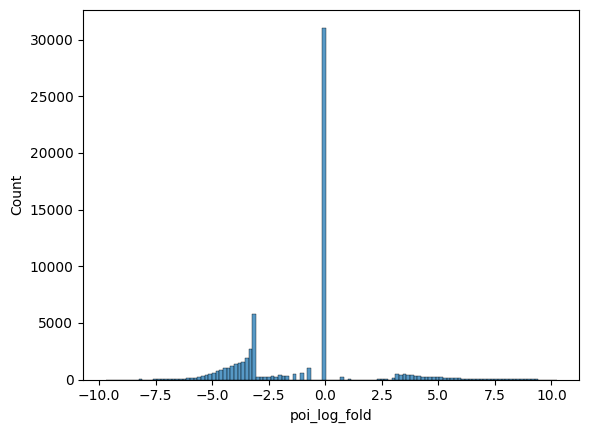

In [5]:
g=sns.histplot(R3_lib["poi_log_fold"])

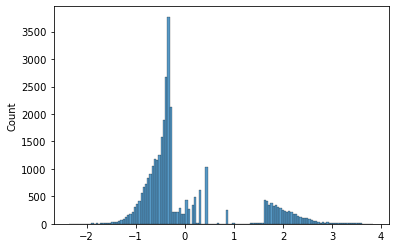

In [160]:
g=sns.histplot(y[:,1])

In [161]:
y_f_cutoff = 0.9419173905476301
y_p_cutoff = -0.4463856871323837

In [162]:
y[:,1]= y[:,1]>y_f_cutoff
y[:,0] = y[:,0]>y_p_cutoff

result = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    X, y, rnn.Joint_BinaryClassificationRNN_gelu
)

Epoch 1/50
206/206 [==============================] - 8s 9ms/step - loss: 0.5417 - accuracy: 0.9869 - recall_6: 0.6768 - precision_6: 0.6135
Epoch 2/50
206/206 [==============================] - 1s 7ms/step - loss: 0.4800 - accuracy: 0.9997 - recall_6: 0.6733 - precision_6: 0.6868
Epoch 3/50
206/206 [==============================] - 1s 7ms/step - loss: 0.4721 - accuracy: 0.9997 - recall_6: 0.6894 - precision_6: 0.6917
Epoch 4/50
206/206 [==============================] - 1s 7ms/step - loss: 0.4656 - accuracy: 0.9997 - recall_6: 0.7262 - precision_6: 0.6996
Epoch 5/50
206/206 [==============================] - 2s 8ms/step - loss: 0.4599 - accuracy: 0.9996 - recall_6: 0.7460 - precision_6: 0.7032
Epoch 6/50
206/206 [==============================] - 2s 8ms/step - loss: 0.4530 - accuracy: 0.9996 - recall_6: 0.7636 - precision_6: 0.7061
Epoch 7/50
206/206 [==============================] - 2s 8ms/step - loss: 0.4429 - accuracy: 0.9996 - recall_6: 0.7747 - precision_6: 0.7077
Epoch 8/50
20

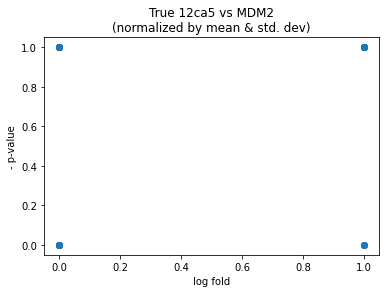

In [163]:
import matplotlib.pyplot as plt

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], y[:, 0], alpha=0.2)
    plt.show()

show_volcano(
    y, protein_of_interest, other_protein, title_addendum="True "
)

In [164]:
model =result.trained_model

In [165]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 0, X, y)

In [166]:
# evaluate accuracy, precision, recall of trianed model
evaluation.classifcation_evaluation(y_f_train, model(X_train)[:,1],y_f_cutoff)

21783 60 2376 2109
accuracy 0.9074749316317229
precision 0.9723374827109267
recall 0.47023411371237456


In [167]:
embedding=umap.embedding_classification(model,X_train)

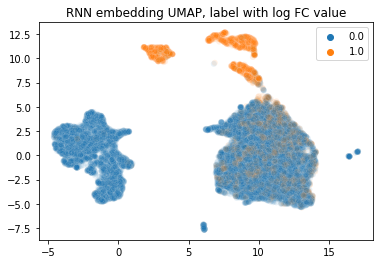

In [168]:
umap.UMAP_log_Fold(embedding, y_f_train)

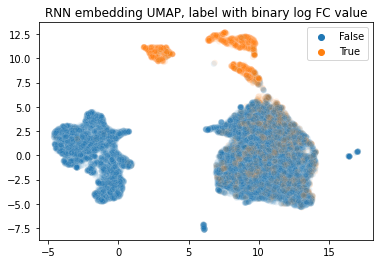

In [169]:
umap.UMAP_binary_log_Fold(embedding, y_f_train,0.5)

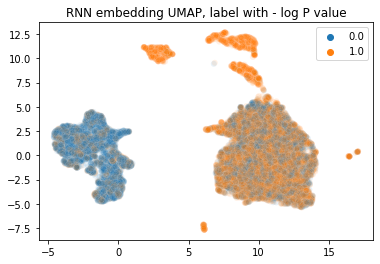

In [170]:
umap.UMAP_log_P(embedding, y_p_train)

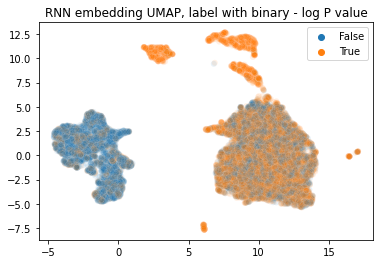

In [171]:
umap.UMAP_binary_log_P(embedding, y_p_train, 0.5)

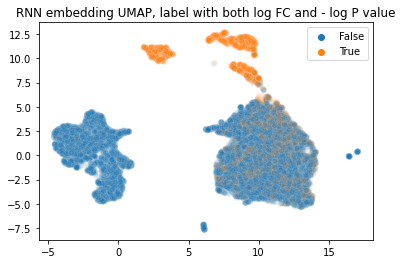

In [172]:
umap.UMAP_joint(embedding, y_f_train, 0.5, y_p_train, 0.5)

In [17]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] > 0.5:
        if y_p_train[i]> 0.5:
            if x2>7 :
                true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [18]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [19]:
ninemer_seq

['KCWVDYAC',
 'TCRGDYAC',
 'GCSLLECK',
 'GWMTWCEE',
 'CGVYAACR',
 'PCGAYCLE',
 'VCTMLECR',
 'YCADLYDY',
 'SCFGDYSC',
 'GWLGDHAR',
 'CRFVDGCE',
 'KCFCDYAC',
 'RGGDYAAC',
 'CPGDYMVC',
 'CKGDYAAW',
 'RCLVDYAC',
 'RCLGDYGC',
 'SCYGDYAC',
 'RCPDYSAC',
 'LCQGDYAC',
 'CNGDYAAW',
 'CVVDYACW',
 'CYGDYACS',
 'VCLGDYAC',
 'SCSLLECR',
 'KCVGDYSC',
 'FCHGDYAW',
 'CQGDYSAC',
 'CRSTWCEE',
 'KCWGYYAC',
 'CRMGDGCD',
 'ACNCYCLE',
 'CLGDYAQC',
 'SCYGDYAW',
 'HCGDYSAC',
 'HCVDYAAC',
 'RCLGYYAC',
 'WCYGDYAC',
 'RWGDYAAC',
 'LCLGDFGC',
 'CDYADTEC',
 'CNGVYAAC',
 'CAADSRDY',
 'CYVDYAAC',
 'CWGYYACG',
 'MCPLLECR',
 'LCCGDYAC',
 'LCFGYYAC',
 'VCWGDYSC',
 'CGDYAEAC',
 'CRLFDGCD',
 'CRGEYAAC',
 'KCVFSDCD',
 'CLGDYAGC',
 'VCCGDYAC',
 'GCYGDYAG',
 'CSGDSASR',
 'YCFGDYSC',
 'CYGVYAAC',
 'VCGGDYAC',
 'CRGDYSYC',
 'HCLGDYAC',
 'CGDYAAMC',
 'CRLFDGCE',
 'YCGDYACL',
 'NCFLLECK',
 'CFGDYSSR',
 'CNFTWGEE',
 'CGDYAALC',
 'GCPMLECK',
 'KCTMLECR',
 'HCGDYAEC',
 'CFDYACWQ',
 'CLGVYAAC',
 'CWDYACHK',
 'ACNVYCME',
 'VCWDYSCW',

In [20]:
import pandas as pd

In [21]:
seq9_s = pd.Series(ninemer_seq)
seq9_s=seq9_s.str.split(r'', expand=True)
seq9_s = seq9_s.drop(0,axis=1)
seq9_s = seq9_s.drop(9,axis=1)

In [22]:
seq9_s

1  2  3  4  5  6  7  8
0     K  C  W  V  D  Y  A  C
1     T  C  R  G  D  Y  A  C
2     G  C  S  L  L  E  C  K
3     G  W  M  T  W  C  E  E
4     C  G  V  Y  A  A  C  R
...  .. .. .. .. .. .. .. ..
1343  C  C  F  G  D  Y  A  A
1344  W  G  D  Y  A  A  C  S
1345  Y  C  R  G  D  Y  A  G
1346  C  V  W  T  L  C  E  E
1347  F  C  G  A  Y  C  E  E

[1348 rows x 8 columns]

In [23]:
frames=[]
for i in range(8):
    frames.append(seq9_s.iloc[:,i].value_counts().sort_index())
seq9_result = pd.concat(frames,axis=1,join='outer')

In [24]:
seq9_result

1    2    3      4      5    6    7    8
A   40   32   57   43.0   69.0  334  473   17
C  550  733   15   17.0    2.0  188  369  614
D    5   11   84  351.0  437.0   16   63   31
E   10    2    5    5.0   19.0  189  138  210
F   47   39  172   15.0   12.0   32    5   20
G   94   96  292  381.0    9.0   66   33   34
H   32    2   47   29.0    4.0    9    2    7
K   56    8    4    2.0    2.0    2    2   61
L   56   40  134   89.0  195.0    2   32    9
M   25   12   39   73.0   16.0    4   19    9
N   23   55   44    3.0    3.0    3   10    3
P   54   22   52   10.0    NaN    2    4    6
Q   13    4    6    NaN    2.0    3    1   12
R   81   91   44    6.0   36.0   36   17  150
S   34   49   31   31.0   32.0   63   80   16
T   29    9   61   97.0    1.0    1    1   14
V  118   31   80   61.0   14.0   27   39    8
W   22   76   73   11.0   89.0   11   23   75
Y   59   36  108  124.0  406.0  360   37   52

<AxesSubplot: >

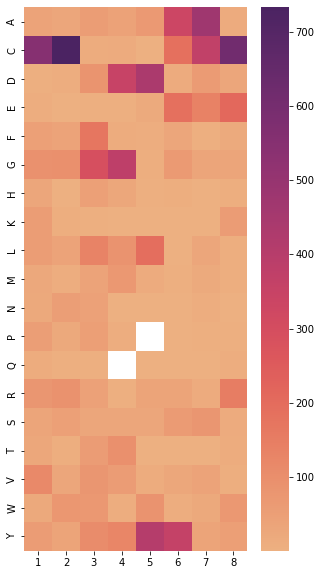

In [25]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(seq9_result, cmap=sns.color_palette("flare", as_cmap=True))

In [28]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('ACR', 95),
 ('PDY', 96),
 ('ECR', 96),
 ('DLR', 107),
 ('AVC', 112),
 ('CGD', 113),
 ('RDY', 132),
 ('LGD', 133),
 ('YAA', 139),
 ('AAC', 142),
 ('LEC', 158),
 ('DYS', 166),
 ('YAC', 334),
 ('GDY', 579),
 ('DYA', 616)]

In [29]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('DYA', 616)
('GDY', 579)
('YAC', 334)
('DYS', 166)
('LEC', 158)


## MDM2 vs 12ca5

In [30]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "MDM2"
other_protein = "12ca5"
X, y = data_loading.build_dataset(
    
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

 - log P value cutoff is -0.4463856871323837, and log FC value cutoff is -0.9419173905476301


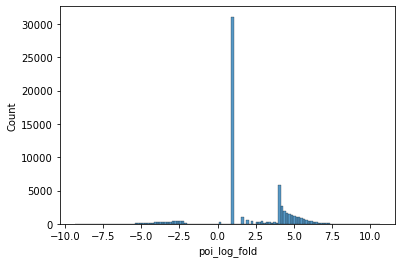

In [31]:
g=sns.histplot(R3_lib["poi_log_fold"])

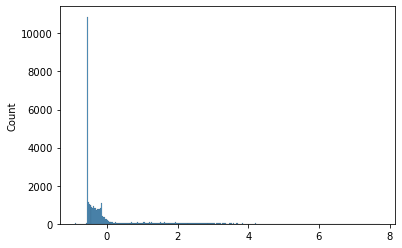

In [32]:
g=sns.histplot(y[:,0])

In [33]:
y_f_cutoff = -0.9419173905476301
y_p_cutoff = -0.4463856871323837

In [34]:
y[:,1]= y[:,1]>y_f_cutoff
y[:,0] = y[:,0]>y_p_cutoff

result = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    X, y, rnn.Joint_BinaryClassificationRNN_gelu
)

Epoch 1/50
206/206 [==============================] - 4s 6ms/step - loss: 0.4937 - accuracy: 0.5176 - recall_1: 0.9255 - precision_1: 0.7774
Epoch 2/50
206/206 [==============================] - 1s 7ms/step - loss: 0.4470 - accuracy: 0.5317 - recall_1: 0.9483 - precision_1: 0.7976
Epoch 3/50
206/206 [==============================] - 1s 6ms/step - loss: 0.4370 - accuracy: 0.5314 - recall_1: 0.9504 - precision_1: 0.8018
Epoch 4/50
206/206 [==============================] - 1s 6ms/step - loss: 0.4311 - accuracy: 0.5316 - recall_1: 0.9526 - precision_1: 0.8039
Epoch 5/50
206/206 [==============================] - 1s 6ms/step - loss: 0.4280 - accuracy: 0.5311 - recall_1: 0.9528 - precision_1: 0.8051
Epoch 6/50
206/206 [==============================] - 1s 6ms/step - loss: 0.4261 - accuracy: 0.5312 - recall_1: 0.9534 - precision_1: 0.8055
Epoch 7/50
206/206 [==============================] - 1s 7ms/step - loss: 0.4234 - accuracy: 0.5307 - recall_1: 0.9541 - precision_1: 0.8063
Epoch 8/50
20

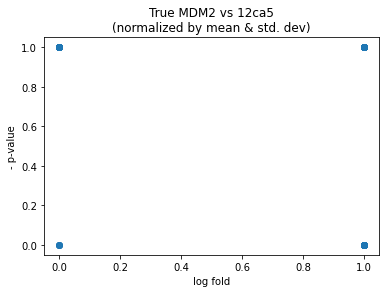

In [35]:
import matplotlib.pyplot as plt

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], y[:, 0], alpha=0.2)
    plt.show()

show_volcano(
    y, protein_of_interest, other_protein, title_addendum="True "
)

In [36]:
model =result.trained_model

In [37]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 0, X, y)

In [38]:
# evaluate accuracy, precision, recall of trianed model
evaluation.classifcation_evaluation(y_f_train, model(X_train)[:,1],y_f_cutoff)

0 0 2094 24234
accuracy 0.9204649042844121
precision 1.0
recall 0.9204649042844121


In [39]:
embedding=umap.embedding_classification(model,X_train)

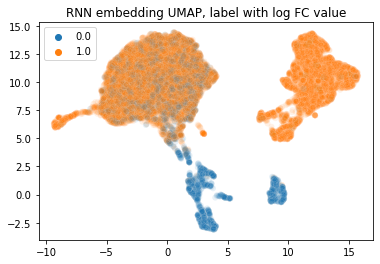

In [40]:
umap.UMAP_log_Fold(embedding, y_f_train)

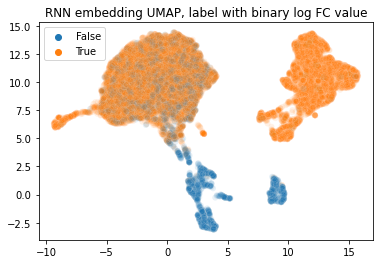

In [41]:
umap.UMAP_binary_log_Fold(embedding, y_f_train,0.5)

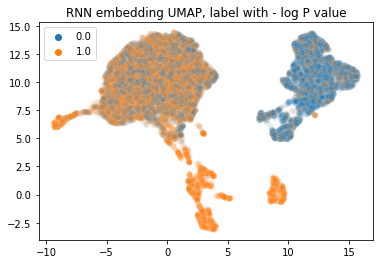

In [42]:
umap.UMAP_log_P(embedding, y_p_train)

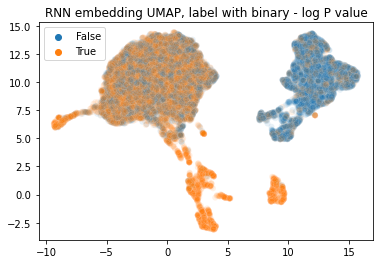

In [43]:
umap.UMAP_binary_log_P(embedding, y_p_train, 0.5)

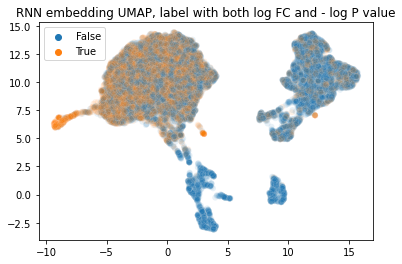

In [44]:
umap.UMAP_joint(embedding, y_f_train, 0.5, y_p_train, 0.5)

In [47]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] > y_f_cutoff:
        if y_p_train[i]> y_p_cutoff:
            if x1 <-7:
                true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [48]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [49]:
ninemer_seq

['LCDFFYCA',
 'FCDWFWGS',
 'FCAGFWCS',
 'CKCFMCWW',
 'FSVWFWCS',
 'FCVWFWCA',
 'FCDWYWCS',
 'FCYFFWCS',
 'CYWWWCKQ',
 'CQTFMCWW',
 'FCDWFGCN',
 'FCVWFWWS',
 'FCDRLWCS',
 'CSTFECWW',
 'FCYWCWCS',
 'FSDWVWCS',
 'CDPFLCYW',
 'FFDWFLCS',
 'YCDWFLCS',
 'FCHWFWCS',
 'CMMDYWCT',
 'FCDLFWCY',
 'YCDWFWCA',
 'DCFFNCWS',
 'CYTFACFW',
 'FCDWYLCS',
 'FCVGLWCS',
 'FCDWLWCC',
 'CCDWFWCS',
 'FCYWYWCS',
 'CSTFEFFW',
 'FCDWFWCY',
 'RKTFMCWW',
 'CTTFMCWW',
 'CVDRFCWW',
 'FCDFYCAY',
 'FCDWFDCH',
 'CSPFECFW',
 'CTTFVCWW',
 'YCYWFWCS',
 'CNLEWCFS',
 'FCDWFHCS',
 'CWWWSYCS',
 'CYDNWCWF',
 'FCDWFLCS',
 'FCYWFWCA',
 'FCVWFWRS',
 'FCDWFECF',
 'FCVWLWCA',
 'FFYWFWCS',
 'FCYWVLCS',
 'CSELWCLW',
 'FCDWFLCA',
 'FKTFMCWW',
 'FCVWSWCS',
 'CYTFMCWW',
 'FCDWLVCN',
 'CNTFMCLW',
 'CSTFECFW',
 'FCAWFWCC',
 'CDSLVFCW',
 'FCYWVWCC',
 'SKTFMCWW',
 'CKTFMSWW',
 'LCGYFCMW',
 'FCYWFLCS',
 'FCVLFWCC',
 'FCEWVWCS',
 'FCDWFWCC',
 'FCEFLGCN',
 'CLTFMCWW',
 'CDFFRCFK',
 'FCDWFVCN',
 'CSNFECFW',
 'FCDWYCCS',
 'FCDLFWCC',
 'FCVWCWCA',

In [50]:
import pandas as pd

In [51]:
seq9_s = pd.Series(ninemer_seq)
seq9_s=seq9_s.str.split(r'', expand=True)
seq9_s = seq9_s.drop(0,axis=1)
seq9_s = seq9_s.drop(9,axis=1)

In [52]:
seq9_s

1  2  3  4  5  6  7  8
0    L  C  D  F  F  Y  C  A
1    F  C  D  W  F  W  G  S
2    F  C  A  G  F  W  C  S
3    C  K  C  F  M  C  W  W
4    F  S  V  W  F  W  C  S
..  .. .. .. .. .. .. .. ..
344  F  C  V  W  F  W  C  S
345  F  W  D  W  F  W  C  A
346  M  C  Y  E  W  F  C  T
347  F  C  D  W  G  W  C  S
348  F  C  D  Y  F  Y  C  S

[349 rows x 8 columns]

In [53]:
frames=[]
for i in range(8):
    frames.append(seq9_s.iloc[:,i].value_counts().sort_index())
seq9_result = pd.concat(frames,axis=1,join='outer')

In [54]:
seq9_result

1      2      3      4      5      6      7      8
C  109.0  217.0    6.0    9.0   10.0  103.0  215.0   28.0
D    2.0   10.0  137.0    5.0    8.0    2.0    NaN    NaN
F  202.0   17.0   19.0   90.0  148.0   10.0   30.0   12.0
G    2.0    NaN    6.0    8.0    3.0    4.0    3.0    1.0
L    7.0    5.0    2.0   25.0   30.0   22.0   10.0    1.0
M    2.0    6.0    1.0    2.0   38.0    1.0    2.0    1.0
P    1.0    2.0    4.0    NaN    NaN    1.0    NaN    5.0
Q    2.0    1.0    NaN    1.0    NaN    1.0    NaN    1.0
R    1.0    2.0    1.0    4.0    2.0    6.0    4.0    1.0
S    2.0   20.0   22.0    6.0    9.0    6.0    3.0  151.0
T    4.0   10.0   46.0    1.0    NaN    1.0    NaN    7.0
V    3.0    3.0   42.0    4.0   34.0    8.0    1.0    1.0
W    2.0    9.0   10.0  179.0   22.0  165.0   70.0   88.0
Y   10.0    7.0   26.0    6.0   18.0    7.0    4.0   11.0
A    NaN    1.0   11.0    1.0    3.0    2.0    1.0   23.0
E    NaN    8.0   10.0    4.0   22.0    6.0    NaN    NaN
K    NaN   24.0    2.0    NaN    1.0    3.0    2.0    2.0
N    NaN    7.0    2.0    4.0    1.0    NaN    3.0   15.0
H    NaN    NaN    2.0    NaN    NaN    1.0    1.0    1.0

<AxesSubplot: >

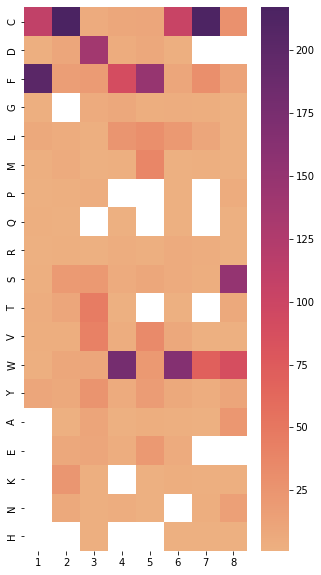

In [55]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(seq9_result, cmap=sns.color_palette("flare", as_cmap=True))

In [56]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('FLC', 23),
 ('VWC', 23),
 ('FMC', 28),
 ('CFW', 28),
 ('MCW', 28),
 ('CVW', 31),
 ('FCV', 34),
 ('CWW', 52),
 ('DWF', 54),
 ('WFW', 64),
 ('FWC', 77),
 ('CDW', 81),
 ('WCS', 90),
 ('FCD', 98),
 ('AFC', 178)]

In [57]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('AFC', 178)
('FCD', 98)
('WCS', 90)
('CDW', 81)
('FWC', 77)


## MDM2 vs mCDH2

In [58]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "MDM2"
other_protein = "mCDH2"
X, y = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

 - log P value cutoff is -0.08396512191297816, and log FC value cutoff is 0.04394247826022299


In [59]:
y_f_cutoff = 0.04394247826022299
y_p_cutoff = -0.08396512191297816

In [60]:
y[:,1]= y[:,1]>y_f_cutoff
y[:,0] = y[:,0]>y_p_cutoff

result = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    X, y, rnn.Joint_BinaryClassificationRNN_gelu
)

Epoch 1/50
369/369 [==============================] - 6s 7ms/step - loss: 0.6192 - accuracy: 0.5998 - recall_2: 0.1307 - precision_2: 0.5113
Epoch 2/50
369/369 [==============================] - 2s 6ms/step - loss: 0.6131 - accuracy: 0.6164 - recall_2: 0.1563 - precision_2: 0.5331
Epoch 3/50
369/369 [==============================] - 2s 6ms/step - loss: 0.6115 - accuracy: 0.6040 - recall_2: 0.1669 - precision_2: 0.5429
Epoch 4/50
369/369 [==============================] - 2s 6ms/step - loss: 0.6106 - accuracy: 0.5960 - recall_2: 0.1643 - precision_2: 0.5422
Epoch 5/50
369/369 [==============================] - 2s 6ms/step - loss: 0.6095 - accuracy: 0.5956 - recall_2: 0.1559 - precision_2: 0.5476
Epoch 6/50
369/369 [==============================] - 3s 7ms/step - loss: 0.6083 - accuracy: 0.5943 - recall_2: 0.1527 - precision_2: 0.5537
Epoch 7/50
369/369 [==============================] - 2s 6ms/step - loss: 0.6074 - accuracy: 0.6058 - recall_2: 0.1500 - precision_2: 0.5564
Epoch 8/50
36

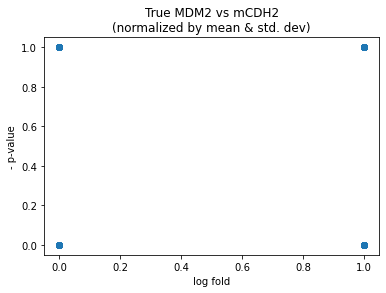

In [61]:
import matplotlib.pyplot as plt

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], y[:, 0], alpha=0.2)
    plt.show()

show_volcano(
    y, protein_of_interest, other_protein, title_addendum="True "
)

In [62]:
model =result.trained_model

In [63]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 0, X, y)

In [64]:
# evaluate accuracy, precision, recall of trianed model
evaluation.classifcation_evaluation(y_f_train, model(X_train)[:,1],y_f_cutoff)

26738 1595 16375 2465
accuracy 0.6190617514256036
precision 0.6071428571428571
recall 0.13083864118895966


In [65]:
embedding=umap.embedding_classification(model,X_train)

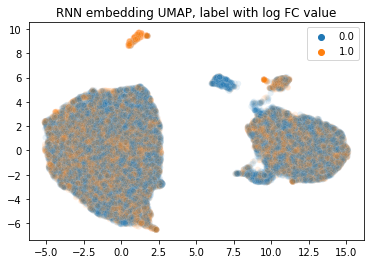

In [66]:
umap.UMAP_log_Fold(embedding, y_f_train)

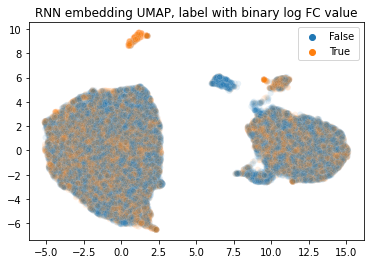

In [67]:
umap.UMAP_binary_log_Fold(embedding, y_f_train,0.5)

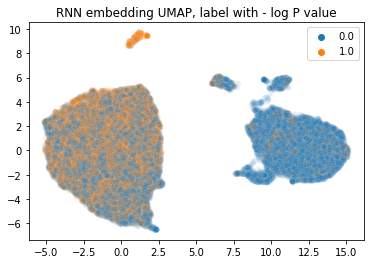

In [68]:
umap.UMAP_log_P(embedding, y_p_train)

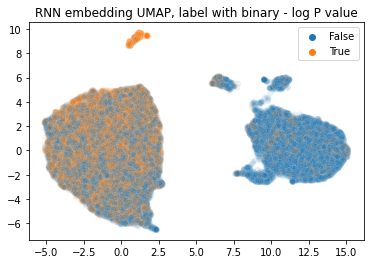

In [69]:
umap.UMAP_binary_log_P(embedding, y_p_train, 0.5)

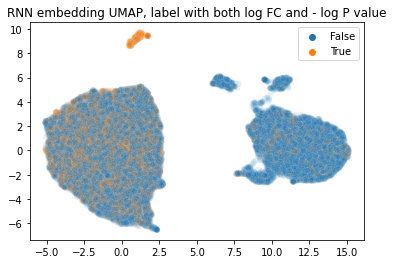

In [70]:
umap.UMAP_joint(embedding, y_f_train, 0.5, y_p_train, 0.5)

In [71]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] >0.5:
        if y_p_train[i]> 0.5:
            if x2>8 :
                true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [72]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [73]:
ninemer_seq

['FCDWYWCA',
 'FCDGLWCS',
 'FCVWFLCC',
 'FCDLLWCS',
 'FCEWLWCS',
 'CSTFECWW',
 'FGDWFWCS',
 'CEYFSCWW',
 'CTTFMCWW',
 'FWDWFWCA',
 'FCVWFWRS',
 'FCYFFWCS',
 'FCSWFWCS',
 'FCDWLWCA',
 'FWDWLWCS',
 'CYTFACFW',
 'FCDWFECF',
 'YCVWFWCS',
 'FKTFMCWW',
 'CKTSMCWW',
 'FCYWFWCY',
 'FRDWFWCS',
 'FCDWFEYN',
 'CDPFLCYW',
 'CTNFECWW',
 'FCDWFWCP',
 'FCYWFWCA',
 'CKTFMGWW',
 'FCDWVWGS',
 'FCDGFWCS',
 'CKSFMCWW',
 'CKCFMCWW',
 'FCVLFWCS',
 'YCDWVWCS',
 'FCAWFWCS',
 'CESFSCWR',
 'CVSFSCWW',
 'FCEWFWCC',
 'FCDLFWCA',
 'FCAGFWCS',
 'WCLWPCSS',
 'FCDWFLCS',
 'FCDCFCCS',
 'FCEWFWCA',
 'FCVWLWCA',
 'FCVWSWCS',
 'CETFACWR',
 'FCFWLWCS',
 'FCDWFACN',
 'FCDWCWCA',
 'FCVWLECN',
 'FCVWFVCN',
 'LCVWVWCS',
 'FCDWFRCS',
 'FCVWVLCS',
 'FCVWFWWS',
 'FCDWFEGN',
 'FCVWFCCS',
 'FCVWFECY',
 'FCDWFWCS',
 'FCDWLVCN',
 'FCDLFWFS',
 'CKTFMCWG',
 'FCPWWCSL',
 'CSSFECWW',
 'FSDWYWCS',
 'FCDCVWCS',
 'FCDWFDCN',
 'FSDWFWCS',
 'VCVWFWCS',
 'FCAWFECN',
 'CLTFMCWW',
 'LCWFRCAA',
 'FCDWFWCA',
 'CMTFMCWW',
 'FCNWFWCS',
 'CKTFMCRW',

In [74]:
import pandas as pd

In [75]:
seq9_s = pd.Series(ninemer_seq)
seq9_s=seq9_s.str.split(r'', expand=True)
seq9_s = seq9_s.drop(0,axis=1)
seq9_s = seq9_s.drop(9,axis=1)

In [76]:
seq9_s

1  2  3  4  5  6  7  8
0    F  C  D  W  Y  W  C  A
1    F  C  D  G  L  W  C  S
2    F  C  V  W  F  L  C  C
3    F  C  D  L  L  W  C  S
4    F  C  E  W  L  W  C  S
..  .. .. .. .. .. .. .. ..
367  C  K  T  F  L  C  W  W
368  F  C  D  W  G  W  C  S
369  F  C  D  W  F  W  W  S
370  F  F  D  W  F  L  C  S
371  F  C  D  W  F  W  C  C

[372 rows x 8 columns]

In [77]:
frames=[]
for i in range(8):
    frames.append(seq9_s.iloc[:,i].value_counts().sort_index())
seq9_result = pd.concat(frames,axis=1,join='outer')

In [78]:
seq9_result

1      2      3      4      5      6      7      8
C  100.0  247.0    5.0   10.0   12.0  105.0  244.0   20.0
F  244.0   10.0   10.0   97.0  166.0    2.0   20.0    2.0
G    1.0    1.0    5.0   10.0    3.0    6.0    3.0    6.0
L    8.0    1.0    2.0   21.0   39.0   25.0    4.0    1.0
M    1.0    8.0    NaN    NaN   43.0    NaN    1.0    NaN
R    1.0    3.0    NaN    5.0    6.0    5.0    5.0    6.0
S    1.0   20.0   27.0    4.0   10.0    2.0    5.0  157.0
V    4.0    2.0   56.0    NaN   35.0    6.0    NaN    NaN
W    2.0    8.0    2.0  220.0    3.0  168.0   79.0   83.0
Y   10.0    7.0   26.0    4.0   20.0    3.0    5.0   19.0
A    NaN    1.0   10.0    NaN    8.0    2.0    2.0   23.0
D    NaN    4.0  157.0    1.0    2.0    1.0    1.0    4.0
E    NaN   12.0    8.0    NaN   23.0   41.0    NaN    NaN
K    NaN   29.0    NaN    NaN    NaN    2.0    1.0    1.0
N    NaN    3.0    4.0    NaN    NaN    NaN    1.0   42.0
Q    NaN    1.0    NaN    NaN    NaN    1.0    NaN    1.0
T    NaN   15.0   56.0    NaN    1.0    NaN    NaN    3.0
H    NaN    NaN    1.0    NaN    NaN    3.0    NaN    NaN
P    NaN    NaN    3.0    NaN    1.0    NaN    1.0    4.0

<AxesSubplot: >

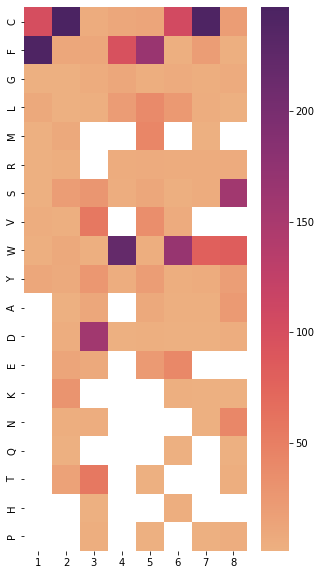

In [79]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(seq9_result, cmap=sns.color_palette("flare", as_cmap=True))

In [80]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('FLC', 26),
 ('WFE', 26),
 ('FMC', 30),
 ('MCW', 31),
 ('FEC', 45),
 ('FCV', 46),
 ('CVW', 47),
 ('CWW', 51),
 ('WFW', 64),
 ('DWF', 73),
 ('FWC', 74),
 ('WCS', 101),
 ('CDW', 104),
 ('FCD', 121),
 ('AFC', 217)]

In [81]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('AFC', 217)
('FCD', 121)
('CDW', 104)
('WCS', 101)
('FWC', 74)


## mCDH2 vs MDM2

In [82]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "mCDH2"
other_protein = "MDM2"
X, y = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

 - log P value cutoff is -0.08396512191297816, and log FC value cutoff is -0.04394247826022299


In [83]:
y_f_cutoff = -0.04394247826022299
y_p_cutoff = -0.08396512191297816

In [84]:
y[:,1]= y[:,1]>y_f_cutoff
y[:,0] = y[:,0]>y_p_cutoff

result = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    X, y, rnn.Joint_BinaryClassificationRNN_gelu
)

Epoch 1/50
369/369 [==============================] - 7s 8ms/step - loss: 0.6203 - accuracy: 0.4587 - recall_3: 0.6722 - precision_3: 0.5915
Epoch 2/50
369/369 [==============================] - 4s 10ms/step - loss: 0.6128 - accuracy: 0.4581 - recall_3: 0.7596 - precision_3: 0.5858
Epoch 3/50
369/369 [==============================] - 3s 9ms/step - loss: 0.6115 - accuracy: 0.4582 - recall_3: 0.7717 - precision_3: 0.5864
Epoch 4/50
369/369 [==============================] - 3s 7ms/step - loss: 0.6108 - accuracy: 0.4581 - recall_3: 0.7685 - precision_3: 0.5866
Epoch 5/50
369/369 [==============================] - 2s 6ms/step - loss: 0.6096 - accuracy: 0.4588 - recall_3: 0.7796 - precision_3: 0.5866
Epoch 6/50
369/369 [==============================] - 2s 6ms/step - loss: 0.6088 - accuracy: 0.4622 - recall_3: 0.7787 - precision_3: 0.5872
Epoch 7/50
369/369 [==============================] - 2s 6ms/step - loss: 0.6081 - accuracy: 0.4644 - recall_3: 0.7814 - precision_3: 0.5867
Epoch 8/50
3

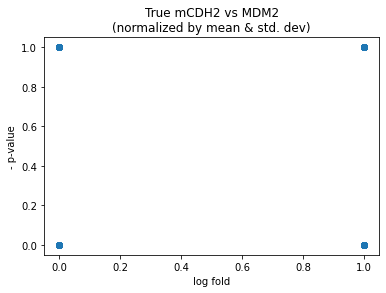

In [85]:
import matplotlib.pyplot as plt

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], y[:, 0], alpha=0.2)
    plt.show()

show_volcano(
    y, protein_of_interest, other_protein, title_addendum="True "
)

In [86]:
model =result.trained_model

In [87]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 0, X, y)

In [88]:
# evaluate accuracy, precision, recall of trianed model
evaluation.classifcation_evaluation(y_f_train, model(X_train)[:,1],y_f_cutoff)

0 0 2754 44419
accuracy 0.9416191465456936
precision 1.0
recall 0.9416191465456936


In [89]:
embedding=umap.embedding_classification(model,X_train)

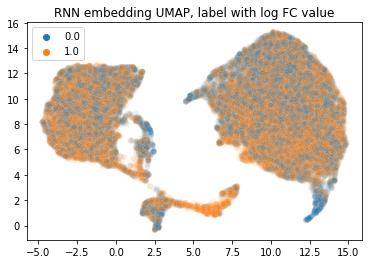

In [90]:
umap.UMAP_log_Fold(embedding, y_f_train)

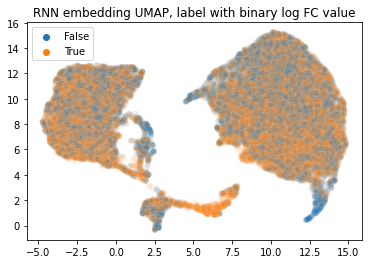

In [91]:
umap.UMAP_binary_log_Fold(embedding, y_f_train,0.5)

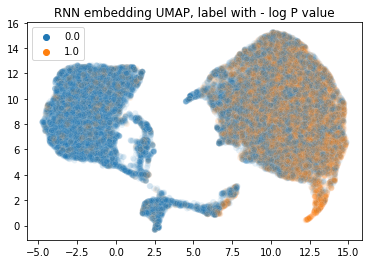

In [92]:
umap.UMAP_log_P(embedding, y_p_train)

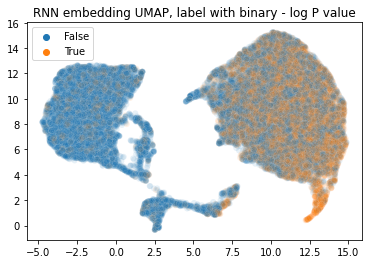

In [93]:
umap.UMAP_binary_log_P(embedding, y_p_train, 0.5)

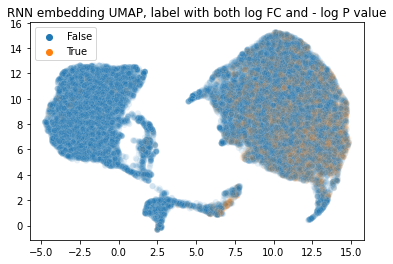

In [94]:
umap.UMAP_joint(embedding, y_f_train, 0.5, y_p_train, 0.5)

In [98]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] > 0.5:
        if y_f_train[i] >0.5:
            if x1>6 and x2<3 :
                true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [99]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [100]:
ninemer_seq

['WRWPGECT',
 'CTSKRRYY',
 'PCFYGGLK',
 'GCTSRWWG',
 'CPFMRCMW',
 'GGPPDCRK',
 'LCGGPARR',
 'DWGGTWCM',
 'ACRVGRSS',
 'LCLWGRRH',
 'VGPTDCRK',
 'CNYPGWGG',
 'SCWKSWCW',
 'VGALVECR',
 'CSLESWRL',
 'WGGGNCWQ',
 'SCVWPWGR',
 'CSNVGRGG',
 'GWVRHLCG',
 'GCCFSGYL',
 'GWSGSECF',
 'CQLTRCQA',
 'MCKDYKGG',
 'CHWQSCTS',
 'GCWGGGGR',
 'ACVKYLGG',
 'CHYWGGWG',
 'SGSTFWCT',
 'WHWKTRCD',
 'CTFPGGGG',
 'ACLFERWR',
 'CLSPSTCS',
 'CNALWRPA',
 'YCFDSCQL',
 'CLRGYNEW',
 'SCPVMWGG',
 'AWERGCES',
 'AWLFERWG',
 'GCRGGGGR',
 'WLGNSSRC',
 'CQSFLRSR',
 'YCSNTSRR',
 'CSSFFWCR',
 'DCFSMLCQ',
 'GGGGNCWQ',
 'VCRGGERR',
 'GGGFFCKN',
 'CQSTFCQA',
 'GWDSFTCL',
 'YCHAGGRG',
 'GGKGACQW',
 'WRSESCYH',
 'CQGWPCLQ',
 'ACTRVGGG',
 'CFGLVPCS',
 'CFVRRGWG',
 'SWGPRNFC',
 'FCGKYWGR',
 'CSGLVCWF',
 'CFRSDCPS',
 'LCDWMWCS',
 'GWARNVTC',
 'SWSGKCGF',
 'CGYANHRR',
 'ACASWYGW',
 'TWGDGGCG',
 'CFADSMTC',
 'CSSVWARG',
 'CAPWRQCQ',
 'MCLGVNWG',
 'CFSDFCQQ',
 'CLPWSLCS',
 'CQFTYCQA',
 'CQPSVKYC',
 'CFTWGWVR',
 'FFVRGGWG',
 'YWHSGCRG',

In [101]:
import pandas as pd

In [102]:
seq9_s = pd.Series(ninemer_seq)
seq9_s=seq9_s.str.split(r'', expand=True)
seq9_s = seq9_s.drop(0,axis=1)
seq9_s = seq9_s.drop(9,axis=1)

In [103]:
seq9_s

1  2  3  4  5  6  7  8
0    W  R  W  P  G  E  C  T
1    C  T  S  K  R  R  Y  Y
2    P  C  F  Y  G  G  L  K
3    G  C  T  S  R  W  W  G
4    C  P  F  M  R  C  M  W
..  .. .. .. .. .. .. .. ..
495  S  H  F  N  E  F  R  C
496  A  F  Y  K  R  H  L  C
497  R  P  F  L  H  C  S  Q
498  Y  C  H  S  G  W  R  G
499  Q  C  F  S  A  W  G  K

[500 rows x 8 columns]

In [104]:
frames=[]
for i in range(8):
    frames.append(seq9_s.iloc[:,i].value_counts().sort_index())
seq9_result = pd.concat(frames,axis=1,join='outer')

In [105]:
seq9_result

1    2   3   4   5    6    7    8
A   24    7  18  31  22   10   27   21
C  218  140   4   4   1  154  102   50
D    4    9  24  21  26    4    3    2
E    3    1   7   6  21   12    3    1
F   17   44  40  42  35   22   12   28
G   50   45  77  70  92   48   57  101
H    6   12  12  13  14   11    8    4
K    1    3  15  17  12    8    4   12
L   26   31  46  31  28   20   28   22
M    7    1   4   4  18    5   11    7
N    2    7  15  23  22    9    6   11
P    7   14  32  25  10    9   11    7
Q    4   19   9   8  10    4   30   26
R    9   15  22  31  36   56   77   68
S   29   40  62  51  44   18   35   52
T   16   15  25  26  20    8   14   17
V   24    8  31  29  22    8    7   10
W   30   79  36  50  41   85   51   57
Y   23   10  21  18  26    9   14    4

<AxesSubplot: >

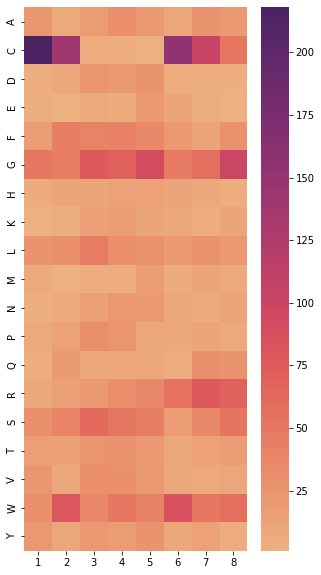

In [106]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(seq9_result, cmap=sns.color_palette("flare", as_cmap=True))

In [107]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('ALC', 15),
 ('GWG', 15),
 ('ASC', 16),
 ('ACT', 16),
 ('ACP', 17),
 ('AGW', 19),
 ('ACQ', 21),
 ('AYC', 21),
 ('WGG', 22),
 ('AGG', 23),
 ('GGG', 25),
 ('ACL', 27),
 ('ACW', 28),
 ('ACS', 36),
 ('ACF', 37)]

In [108]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('ACF', 37)
('ACS', 36)
('ACW', 28)
('ACL', 27)
('GGG', 25)


## 12ca5 vs mCDH2

In [109]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "12ca5"
other_protein = "mCDH2"
X, y = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

 - log P value cutoff is -0.33058129229327954, and log FC value cutoff is 0.955421147441985


In [110]:
y_f_cutoff = 0.955421147441985
y_p_cutoff = -0.33058129229327954

In [111]:
y[:,1]= y[:,1]>y_f_cutoff
y[:,0] = y[:,0]>y_p_cutoff

result = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    X, y, rnn.Joint_BinaryClassificationRNN_gelu
)

Epoch 1/50
269/269 [==============================] - 5s 8ms/step - loss: 0.4407 - accuracy: 0.9350 - recall_4: 0.1438 - precision_4: 0.7171
Epoch 2/50
269/269 [==============================] - 2s 7ms/step - loss: 0.3943 - accuracy: 0.9600 - recall_4: 0.2147 - precision_4: 0.7965
Epoch 3/50
269/269 [==============================] - 2s 6ms/step - loss: 0.3863 - accuracy: 0.9595 - recall_4: 0.2285 - precision_4: 0.8107
Epoch 4/50
269/269 [==============================] - 2s 6ms/step - loss: 0.3814 - accuracy: 0.9584 - recall_4: 0.2423 - precision_4: 0.8190
Epoch 5/50
269/269 [==============================] - 2s 6ms/step - loss: 0.3773 - accuracy: 0.9581 - recall_4: 0.2474 - precision_4: 0.8381
Epoch 6/50
269/269 [==============================] - 2s 6ms/step - loss: 0.3746 - accuracy: 0.9570 - recall_4: 0.2441 - precision_4: 0.8603
Epoch 7/50
269/269 [==============================] - 2s 6ms/step - loss: 0.3714 - accuracy: 0.9543 - recall_4: 0.2471 - precision_4: 0.8907
Epoch 8/50
26

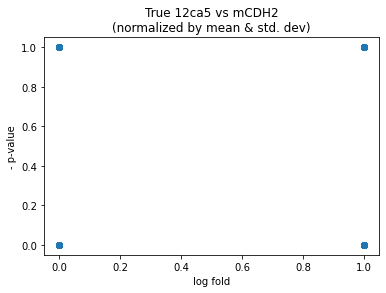

In [112]:
import matplotlib.pyplot as plt

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], y[:, 0], alpha=0.2)
    plt.show()

show_volcano(
    y, protein_of_interest, other_protein, title_addendum="True "
)

In [113]:
model =result.trained_model

In [114]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 0, X, y)

In [115]:
# evaluate accuracy, precision, recall of trianed model
evaluation.classifcation_evaluation(y_f_train, model(X_train)[:,1],y_f_cutoff)

29634 67 2577 2055
accuracy 0.9229895435878018
precision 0.9684260131950989
recall 0.44365284974093266


In [116]:
embedding=umap.embedding_classification(model,X_train)

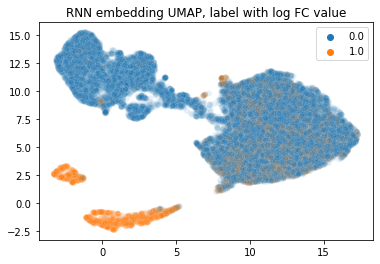

In [117]:
umap.UMAP_log_Fold(embedding, y_f_train)

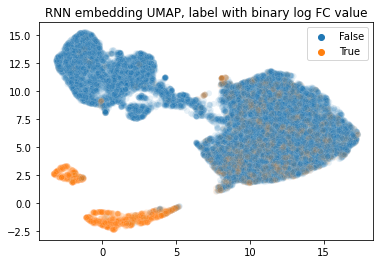

In [118]:
umap.UMAP_binary_log_Fold(embedding, y_f_train,0.5)

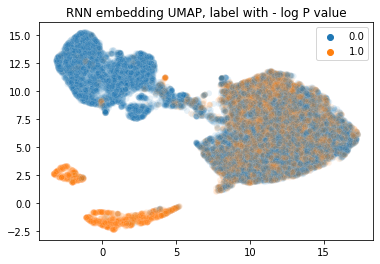

In [119]:
umap.UMAP_log_P(embedding, y_p_train)

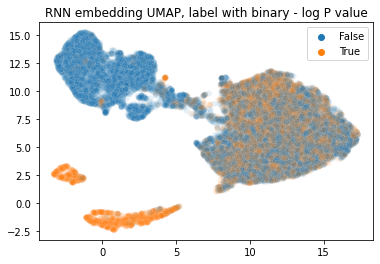

In [120]:
umap.UMAP_binary_log_P(embedding, y_p_train, 0.5)

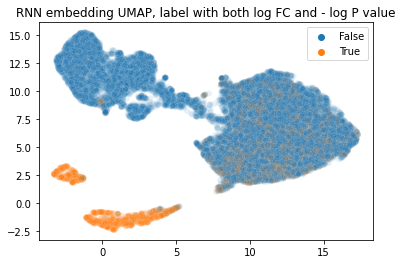

In [121]:
umap.UMAP_joint(embedding, y_f_train, 0.5, y_p_train, 0.5)

In [122]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] > 0.5:
        if y_p_train[i]> 0.5:
            if x1 <6 and x2 <4 :
                true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [123]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [124]:
ninemer_seq

['HCTMLECR',
 'CWMTWCEE',
 'CRATWWEE',
 'GWGDYAAC',
 'SNGDYAAC',
 'GCLGVYAC',
 'CRATWGEE',
 'VCVGDYAC',
 'HCMLEGCN',
 'GCLGYYAC',
 'KCDYAAHC',
 'RCTMLECK',
 'QCGDYAAC',
 'YCRGDYAF',
 'ACFGDSAC',
 'LCLCDYAC',
 'RCNSYCLE',
 'LCFVDYAC',
 'GWVGDYAC',
 'CNGDYAGC',
 'CPCDYAAC',
 'ECGDYAEC',
 'CRLYDGCD',
 'CWDYSCWA',
 'LCWVDYAC',
 'TCCDYACW',
 'PCFHLDCR',
 'KCFGDYAC',
 'CCEDLFDY',
 'KCWDYSCW',
 'CVGDYACR',
 'CGDYASYC',
 'QCTMLECK',
 'VCSLLECR',
 'GCLGAYAC',
 'CRGDYACR',
 'PGFMLECR',
 'CWMTWWEE',
 'GCGDYAAR',
 'VCLGDFAC',
 'ACSYFEEC',
 'CWMPWCEV',
 'HCLGDYAC',
 'CYGDYACG',
 'CRWYDGCV',
 'CFGDYACA',
 'AWGDYAAC',
 'LCWGEYAC',
 'PCTLLECS',
 'CNGHYAAC',
 'TCTMLECR',
 'VCSMLECK',
 'CPGDYSRC',
 'CGDYSACR',
 'CVWTLCEE',
 'NCFMLECR',
 'CWMPWWEE',
 'RCSGDYAC',
 'SCFHLECR',
 'CREVDGCG',
 'VCGDHAAC',
 'YCFGDYVC',
 'CYGDYSAC',
 'CVWTWCVE',
 'CFGDYAAC',
 'GCMGDYAC',
 'NCRGDYAW',
 'RCLGDYSR',
 'RSVGDYAC',
 'VCPMLECK',
 'VWPMLECK',
 'ACNCYCLE',
 'TCVGDYAC',
 'CGDYSARW',
 'LCGGDYAC',
 'CGDYAACL',
 'YCHMLECR',

In [125]:
import pandas as pd

In [126]:
seq9_s = pd.Series(ninemer_seq)
seq9_s=seq9_s.str.split(r'', expand=True)
seq9_s = seq9_s.drop(0,axis=1)
seq9_s = seq9_s.drop(9,axis=1)

In [127]:
seq9_s

1  2  3  4  5  6  7  8
0     H  C  T  M  L  E  C  R
1     C  W  M  T  W  C  E  E
2     C  R  A  T  W  W  E  E
3     G  W  G  D  Y  A  A  C
4     S  N  G  D  Y  A  A  C
...  .. .. .. .. .. .. .. ..
1434  G  C  N  S  Y  C  Y  E
1435  K  C  F  G  D  S  A  C
1436  C  W  M  T  G  G  E  E
1437  L  C  F  H  L  E  C  K
1438  P  C  F  H  L  E  W  R

[1439 rows x 8 columns]

In [128]:
frames=[]
for i in range(8):
    frames.append(seq9_s.iloc[:,i].value_counts().sort_index())
seq9_result = pd.concat(frames,axis=1,join='outer')

In [129]:
seq9_result

1    2    3    4    5    6    7    8
A   42   34   62   66   81  328  472   21
C  610  761   15   18    2  209  417  637
D    5   16  114  328  456   17   54   34
E   15    5    8    2   33  203  153  218
F   44   40  184   16   12   29    6   28
G  104  112  281  387   15  103   37   36
H   33    2   54   34    7    9   17    8
K   66    6    3    3    1    1    3   60
L   61   48  143   97  205    3   40   12
M   26   12   38   84   16    5   26   16
N   25   64   53    3    3    4   12    9
P   63   23   50   15    2    3    5    7
Q   13    2    8    1    2    2    7   11
R   87  110   48    7   39   38   19  158
S   32   49   36   38   28   65   73   22
T   28   14   63  105    2    1    1   12
V  104   36   82   71   20   34   40   28
W   19   72   81    9   97   12   21   77
Y   62   33  116  155  418  373   36   45

<AxesSubplot: >

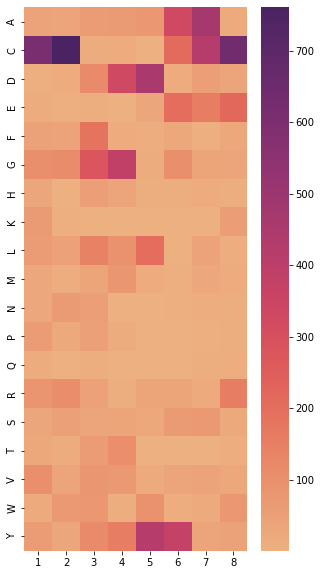

In [130]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(seq9_result, cmap=sns.color_palette("flare", as_cmap=True))

In [131]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('ACG', 98),
 ('CLG', 98),
 ('DLR', 101),
 ('ECR', 104),
 ('ACR', 111),
 ('CGD', 114),
 ('RDY', 124),
 ('YAA', 136),
 ('LGD', 137),
 ('AAC', 141),
 ('DYS', 171),
 ('LEC', 174),
 ('YAC', 335),
 ('GDY', 580),
 ('DYA', 620)]

In [132]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('DYA', 620)
('GDY', 580)
('YAC', 335)
('LEC', 174)
('DYS', 171)


## mCDH2 vs 12ca5

In [133]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "mCDH2"
other_protein = "12ca5"
X, y = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

 - log P value cutoff is -0.33058129229327954, and log FC value cutoff is -0.955421147441985


In [134]:
y_f_cutoff = -0.955421147441985
y_p_cutoff = -0.33058129229327954

In [135]:
y[:,1]= y[:,1]>y_f_cutoff
y[:,0] = y[:,0]>y_p_cutoff

result = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    X, y, rnn.Joint_BinaryClassificationRNN_gelu
)

Epoch 1/50
269/269 [==============================] - 8s 9ms/step - loss: 0.4551 - accuracy: 0.6736 - recall_5: 0.7525 - precision_5: 0.8537
Epoch 2/50
269/269 [==============================] - 2s 7ms/step - loss: 0.4017 - accuracy: 0.6981 - recall_5: 0.7544 - precision_5: 0.8914
Epoch 3/50
269/269 [==============================] - 2s 7ms/step - loss: 0.3939 - accuracy: 0.7007 - recall_5: 0.7558 - precision_5: 0.8968
Epoch 4/50
269/269 [==============================] - 2s 7ms/step - loss: 0.3885 - accuracy: 0.7030 - recall_5: 0.7569 - precision_5: 0.9001
Epoch 5/50
269/269 [==============================] - 2s 8ms/step - loss: 0.3854 - accuracy: 0.7038 - recall_5: 0.7576 - precision_5: 0.9021
Epoch 6/50
269/269 [==============================] - 2s 6ms/step - loss: 0.3826 - accuracy: 0.7049 - recall_5: 0.7594 - precision_5: 0.9024
Epoch 7/50
269/269 [==============================] - 2s 9ms/step - loss: 0.3789 - accuracy: 0.7067 - recall_5: 0.7615 - precision_5: 0.9039
Epoch 8/50
26

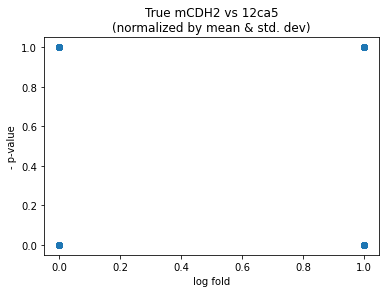

In [136]:
import matplotlib.pyplot as plt

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], y[:, 0], alpha=0.2)
    plt.show()

show_volcano(
    y, protein_of_interest, other_protein, title_addendum="True "
)

In [137]:
model =result.trained_model

In [138]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 0, X, y)

In [139]:
# evaluate accuracy, precision, recall of trianed model
evaluation.classifcation_evaluation(y_f_train, model(X_train)[:,1],y_f_cutoff)

0 0 2227 32106
accuracy 0.9351352925756561
precision 1.0
recall 0.9351352925756561


In [140]:
embedding=umap.embedding_classification(model,X_train)

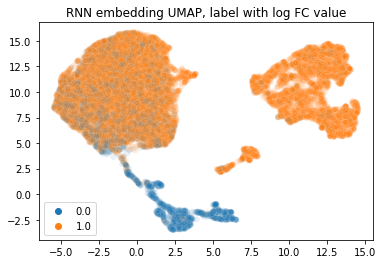

In [141]:
umap.UMAP_log_Fold(embedding, y_f_train)

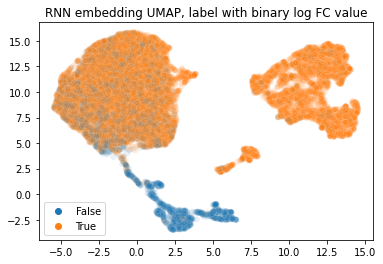

In [142]:
umap.UMAP_binary_log_Fold(embedding, y_f_train,0.5)

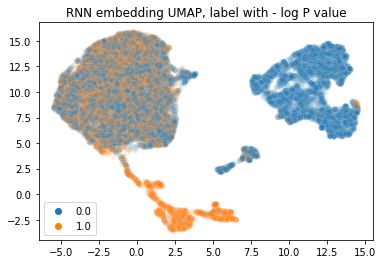

In [143]:
umap.UMAP_log_P(embedding, y_p_train)

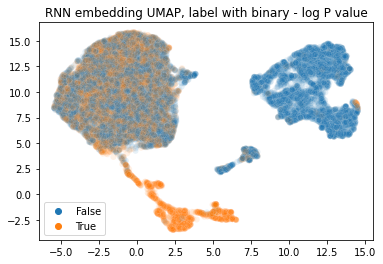

In [144]:
umap.UMAP_binary_log_P(embedding, y_p_train, 0.5)

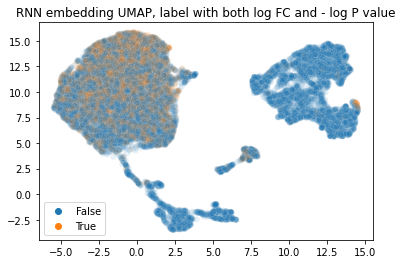

In [145]:
umap.UMAP_joint(embedding, y_f_train, 0.5, y_p_train, 0.5)

In [147]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] > y_f_cutoff:
        if y_p_train[i]> y_p_cutoff:
            if x1 < 5 and x2 >2.5:
                true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [148]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [149]:
ninemer_seq

['FCLSDCRS',
 'CGNNTTCD',
 'CERSLYHC',
 'LWGGLLWR',
 'CYDMLSCR',
 'SCLPWKAC',
 'VCLSRYCG',
 'RCLTTACG',
 'CEGRSGCL',
 'VCKGDKCF',
 'SCHYSSLC',
 'HCMGDLCY',
 'GCYQYWGC',
 'SCLPWGCS',
 'CFHGLRSC',
 'LCFSDTCW',
 'CTLKDCLR',
 'PCGASCHY',
 'TCQSAGYC',
 'CVENRWSC',
 'VCMGFACS',
 'SCFDSYCF',
 'CNRVLVCV',
 'ACTPRGCF',
 'QCSSFSCR',
 'CGLLGYMC',
 'ACGWKSCE',
 'ACQSRMAC',
 'KCSQVSLC',
 'CLKMWELC',
 'CSRVSSVC',
 'MCFFNDTC',
 'CWGHYTCA',
 'VCLSGGSC',
 'CLRGVYCY',
 'CWMSFCSS',
 'CYLNHCTH',
 'GCSEGFCS',
 'TCLSRVCG',
 'CNFWFPCD',
 'VCGSMCGH',
 'HCKNMVCG',
 'CTHMECKL',
 'SCTPLCSV',
 'SCYRLEHC',
 'CNGKSPLC',
 'CSTVYCGH',
 'CLTQASPC',
 'SCNVAYYC',
 'CGSWSCRY',
 'CWVGYCQS',
 'CVNNVGKC',
 'MCAWRLCP',
 'CGSWMCSY',
 'LCNPSCVT',
 'ACRLATCA',
 'RCLSQDCR',
 'VCGHKYCT',
 'CGHSKCHS',
 'YCGWDGAC',
 'CWFGNYEC',
 'CLFNACSY',
 'ACLGYCFQ',
 'CLMRGSAC',
 'PCVYEWWC',
 'CTRVNCVW',
 'CNSSSWVC',
 'CFLEYFLL',
 'PCYDENCH',
 'CPSVLCRT',
 'CWGWQCVR',
 'CHHFTCWW',
 'CYGSFCRS',
 'CVGRTVCS',
 'CGSWVTCM',
 'CFYQNPCF',
 'CNTTLYCG',

In [150]:
import pandas as pd

In [151]:
seq9_s = pd.Series(ninemer_seq)
seq9_s=seq9_s.str.split(r'', expand=True)
seq9_s = seq9_s.drop(0,axis=1)
seq9_s = seq9_s.drop(9,axis=1)

In [152]:
seq9_s

1  2  3  4  5  6  7  8
0      F  C  L  S  D  C  R  S
1      C  G  N  N  T  T  C  D
2      C  E  R  S  L  Y  H  C
3      L  W  G  G  L  L  W  R
4      C  Y  D  M  L  S  C  R
...   .. .. .. .. .. .. .. ..
21878  R  C  A  P  T  C  L  N
21879  C  H  P  M  E  C  G  R
21880  K  C  D  H  R  Y  F  C
21881  C  M  N  Y  W  L  C  R
21882  V  C  H  S  H  C  R  L

[21883 rows x 8 columns]

In [153]:
frames=[]
for i in range(8):
    frames.append(seq9_s.iloc[:,i].value_counts().sort_index())
seq9_result = pd.concat(frames,axis=1,join='outer')

In [154]:
seq9_result

1      2     3     4     5     6     7     8
A    723    223  1054  1309  1383   888   855   931
C  11621  10059   102    50    76  7151  7757  6730
D    337    463   839   710   734   364   318   344
E    255    234   445   405   469   276   225   253
F    473    715  1204  1370  1298   869   719   716
G   1055   1229  2577  2320  2087  1290  1279  1310
H    360    567   942   941   980   641   608   687
K    253    322   735   704   749   486   475   561
L    994   1091  1890  1851  1826  1289  1286  1414
M    427    433   613   605   684   518   512   590
N    446    696  1053   961  1091   605   565   535
P    548    534  1038  1066   814   609   489   574
Q    282    331   500   433   518   362   388   449
R    275    421  1154  1492  1586  1337  1469  1621
S   1267   1471  2704  2523  2505  1629  1562  1514
T    552    744  1264  1085  1117   775   718   795
V   1127    799  1336  1126  1307   832   970  1149
W    182    697  1009  1326  1206   937   667   618
Y    706    854  1424  1606  1453  1025  1021  1092

<AxesSubplot: >

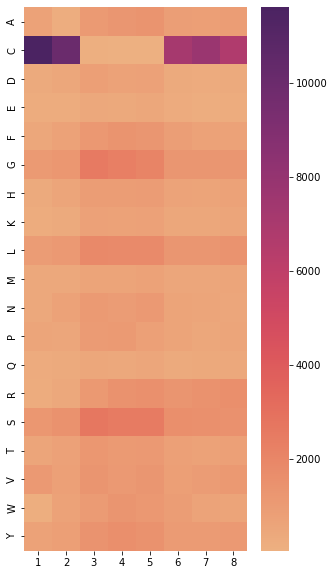

In [155]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(seq9_result, cmap=sns.color_palette("flare", as_cmap=True))

In [156]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('ACW', 698),
 ('ACN', 761),
 ('AAC', 777),
 ('ACF', 778),
 ('AYC', 787),
 ('ACT', 840),
 ('ACV', 909),
 ('ACY', 971),
 ('ALC', 1077),
 ('AGC', 1082),
 ('AVC', 1165),
 ('ACL', 1220),
 ('ACG', 1312),
 ('ASC', 1363),
 ('ACS', 1610)]

In [157]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('ACS', 1610)
('ASC', 1363)
('ACG', 1312)
('ACL', 1220)
('AVC', 1165)


## Load Data, Get Representation, Train Binary Classification RNN Model, CrossFold Best Model¶
(Binary classification on log fold change)

In [21]:
y_fc = y[:,1]> y_f_cutoff
y_p = y[:,0]

result1 = experiment.BinaryClassificationExperiment().run_cross_validation_experiment(
    X, y_fc, rnn.BinaryClassificationRNN
)

Epoch 1/16
206/206 [==============================] - 3s 5ms/step - loss: 0.1304 - accuracy: 0.8430 - recall_1: 0.1931 - precision_1: 0.7236
Epoch 2/16
206/206 [==============================] - 1s 5ms/step - loss: 0.1064 - accuracy: 0.8696 - recall_1: 0.3181 - precision_1: 0.8655
Epoch 3/16
206/206 [==============================] - 1s 5ms/step - loss: 0.1025 - accuracy: 0.8726 - recall_1: 0.3279 - precision_1: 0.8855
Epoch 4/16
206/206 [==============================] - 1s 6ms/step - loss: 0.0989 - accuracy: 0.8764 - recall_1: 0.3505 - precision_1: 0.8882
Epoch 5/16
206/206 [==============================] - 1s 5ms/step - loss: 0.0953 - accuracy: 0.8837 - recall_1: 0.4012 - precision_1: 0.8824
Epoch 6/16
206/206 [==============================] - 1s 5ms/step - loss: 0.0933 - accuracy: 0.8864 - recall_1: 0.4070 - precision_1: 0.9014
Epoch 7/16
206/206 [==============================] - 1s 5ms/step - loss: 0.0915 - accuracy: 0.8886 - recall_1: 0.4127 - precision_1: 0.9167
Epoch 8/16
20

In [23]:
model =result1[1].trained_model

In [24]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 1, X, y)    

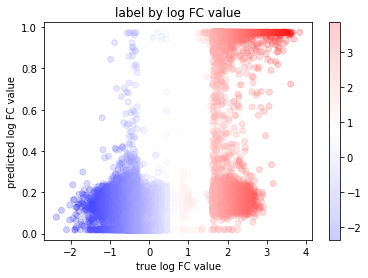

In [25]:
#Train samples classification results (TRAIN)
scatter_plots.Predicted_vs_actual_plot(y_f_train, model(X_train), y_f_train, "log FC" , "log FC", "log FC")

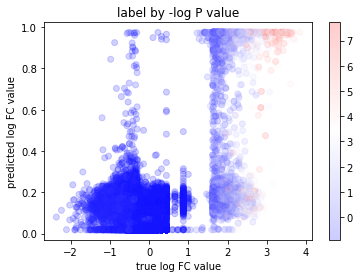

In [26]:
#Train samples classification results (TRAIN) 
scatter_plots.Predicted_vs_actual_plot(y_f_train, model(X_train), y_p_train, "log FC" , "log FC", "-log P")

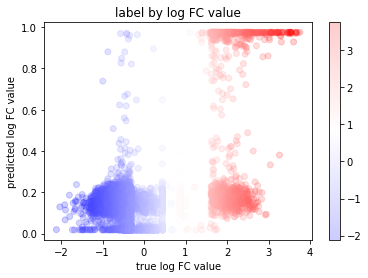

In [27]:
#Train samples classification results (TEST)
scatter_plots.Predicted_vs_actual_plot(y_f_test, model(X_test), y_f_test, "log FC" , "log FC", "log FC")

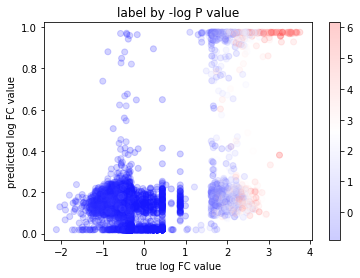

In [28]:
#Train samples classification results (TEST)
scatter_plots.Predicted_vs_actual_plot(y_f_test, model(X_test), y_p_test, "log FC" , "log FC", "-log P")

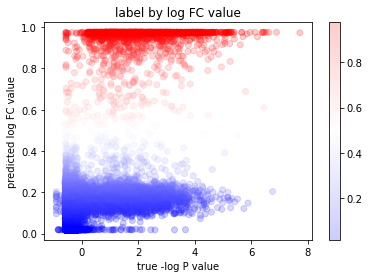

In [29]:
#Train samples classification results 
scatter_plots.Predicted_vs_actual_plot(y_p_train, model(X_train), model(X_train), "-log P" , "log FC", "log FC")

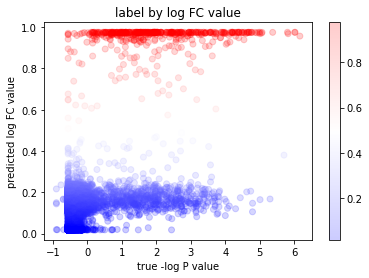

In [30]:
#Train samples classification results
scatter_plots.Predicted_vs_actual_plot(y_p_test, model(X_test), model(X_test), "-log P" , "log FC", "log FC")

In [31]:
# evaluate accuracy, precision, recall of trianed model
evaluation.classifcation_evaluation(y_f_train, model(X_train),y_f_cutoff)

21601 53 2726 1949
accuracy 0.8944509856052262
precision 0.9735264735264735
recall 0.4168983957219251


In [32]:
embedding=umap.embedding_classification(model,X_train)

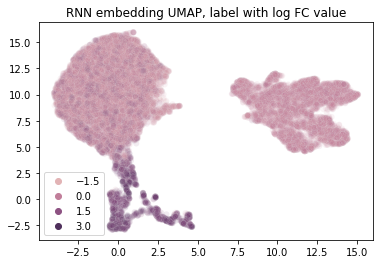

In [33]:
umap.UMAP_log_Fold(embedding, y_f_train)

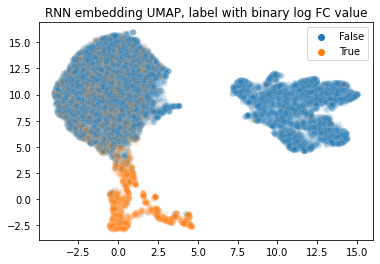

In [34]:
umap.UMAP_binary_log_Fold(embedding, y_f_train, y_f_cutoff)

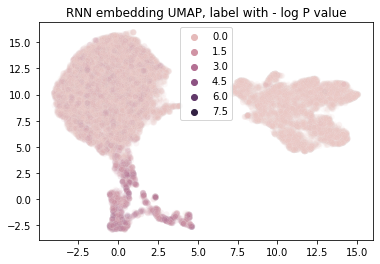

In [35]:
umap.UMAP_log_P(embedding, y_p_train)

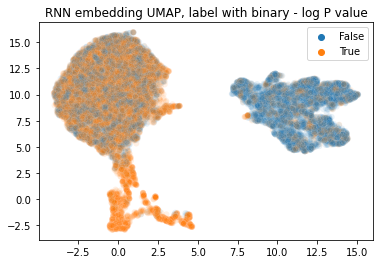

In [36]:
umap.UMAP_binary_log_P(embedding, y_p_train, y_p_cutoff)

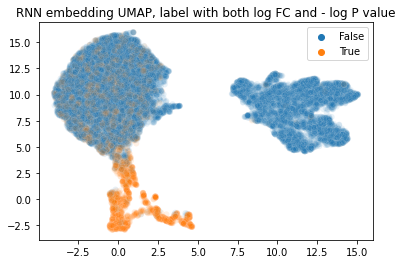

In [37]:
umap.UMAP_joint(embedding, y_f_train,y_f_cutoff, y_p_train, y_p_cutoff)

[(-4.0, 0.0)]

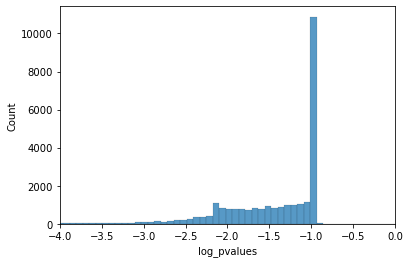

In [38]:
g=sns.histplot(R3_lib['log_pvalues'])
g.set(xlim=(-4,0))

<AxesSubplot: xlabel='log_pvalues', ylabel='Count'>

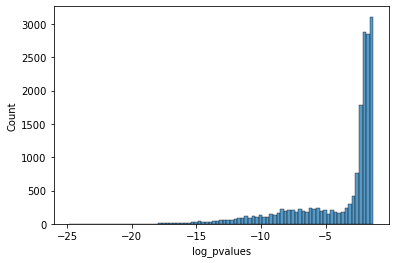

In [39]:
log_pvalues_cutoff = -R3_lib['log_pvalues'] > -np.log10(0.05)
sns.histplot(R3_lib.loc[log_pvalues_cutoff==True]['log_pvalues'])

In [40]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] > y_f_cutoff:
        if y_p_train[i]>y_p_cutoff:
            if x2 >5.5:
                true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [41]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [42]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('AYC', 68),
 ('ACF', 72),
 ('ACH', 74),
 ('ACT', 75),
 ('AAC', 78),
 ('ACR', 84),
 ('ALC', 92),
 ('ACY', 99),
 ('ACV', 115),
 ('ACL', 118),
 ('AGC', 122),
 ('ACG', 133),
 ('AVC', 142),
 ('ASC', 156),
 ('ACS', 164)]

In [43]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('ACS', 164)
('ASC', 156)
('AVC', 142)
('ACG', 133)
('AGC', 122)


In [3]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")

protein_of_interest = "mCDH2"
other_protein = "12ca5"

# protein_of_interest = "12ca5"
# other_protein = "mCDH2"

X, y = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

 - log P value cutoff is -0.33058129229327954, and log FC value cutoff is -0.955421147441985


In [4]:
y_f = y[:,1]
y_p = y[:,0]

# result2 = experiment.SingleRegressionExperiment().run_adhoc_experiment(
#     X, y_f, rnn.SingleRegression_CNNRNN, exp_name=None
# )

test = experiment.SingleRegressionExperiment().run_adhoc_experiment(
    X, y_f, rnn.SingleRegression_CNNRNN, exp_name=None
)

2023-01-11 21:40:29.352498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
242/242 [==============================] - 9s 37ms/step - loss: 0.8896 - fold_rmse: 0.8896 - accuracy: 0.0000e+00 - val_loss: 0.9998 - val_fold_rmse: 1.0013 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/20
242/242 [==============================] - 9s 36ms/step - loss: 0.7779 - fold_rmse: 0.7781 - accuracy: 0.0000e+00 - val_loss: 0.7917 - val_fold_rmse: 0.7935 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/20
242/242 [==============================] - 9s 36ms/step - loss: 0.7493 - fold_rmse: 0.7501 - accuracy: 0.0000e+00 - val_loss: 0.7244 - val_fold_rmse: 0.7261 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/20
242/242 [==============================] - 9s 36ms/step - loss: 0.7364 - fold_rmse: 0.7363 - accuracy: 0.0000e+00 - val_loss: 0.7241 - val_fold_rmse: 0.7256 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/20
242/242 [==============================] - 9s 36ms/step - loss: 0.7286 - fold_rmse: 0.7296 - accuracy: 0.0000e+00 - val_loss: 0.7184 - val_fold_rmse: 0.7198 

KeyboardInterrupt: 

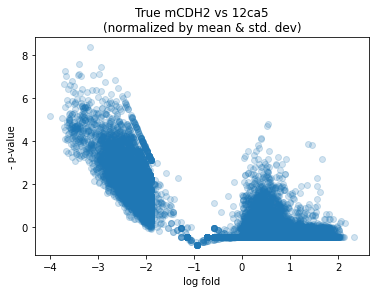

In [8]:
import matplotlib.pyplot as plt

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], y[:, 0], alpha=0.2)
    plt.show()

show_volcano(
    y, protein_of_interest, other_protein, title_addendum="True "
)

In [9]:
# import os
# import pickle
# exp_name = 'SingleRegressionRNN_2LSTM_Dense32_epoch10'
# exp_dir = os.path.join('experiments', exp_name)
# os.makedirs(exp_dir, exist_ok=True)
# with open(os.path.join(exp_dir, 'history.pkl'), 'wb') as f:
#     pickle.dump(history.history, f)

In [4]:
y_p_cutoff= -0.33058129229327954
y_f_cutoff= -0.9339957475557442

In [5]:
model =result2.trained_model

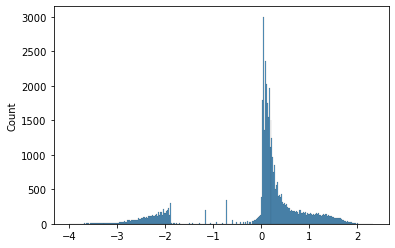

In [6]:
g=sns.histplot(y_f)

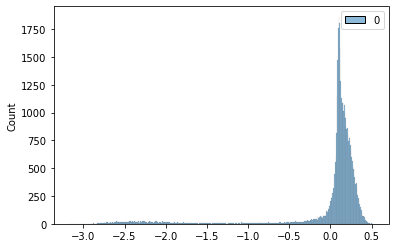

In [7]:
g=sns.histplot(model(X))

<AxesSubplot: ylabel='Count'>

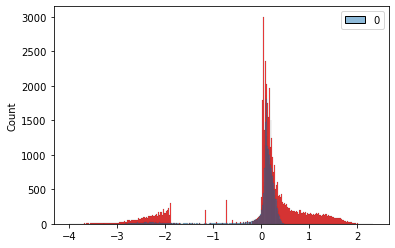

In [8]:
fig, ax = plt.subplots()
sns.histplot(y_f, ax=ax, color = 'r')
sns.histplot(model(X), ax=ax, color ='b')

In [9]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 0, X, y)

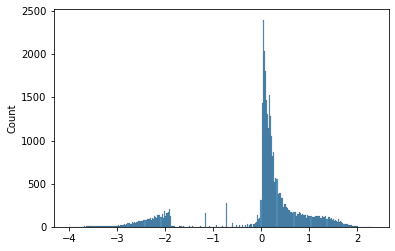

In [10]:
g=sns.histplot(y_f_train)

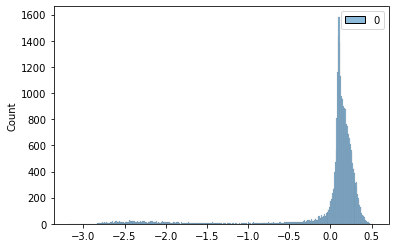

In [11]:
g=sns.histplot(model(X_train))

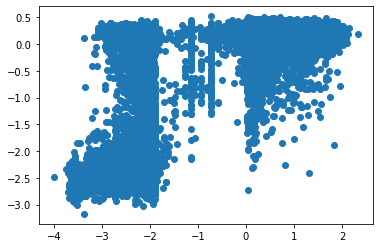

In [12]:
g=plt.scatter(y_f,model(X))

<AxesSubplot: ylabel='Count'>

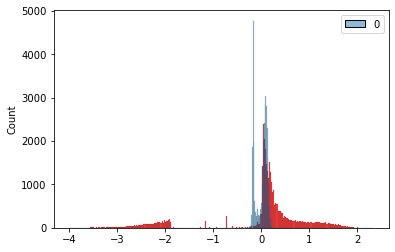

In [16]:
fig, ax = plt.subplots()
sns.histplot(y_f_train, ax=ax, color = 'r')
sns.histplot(model(X_train), ax=ax, color ='b')

NameError: name 'idx' is not defined

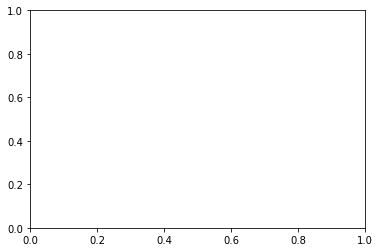

In [17]:
fig, ax = plt.subplots()
g=sns.histplot(y_f[idx], ax=ax, color = 'r')
sns.histplot(model(X[idx]), ax=ax, color ='b')

<AxesSubplot: ylabel='Count'>

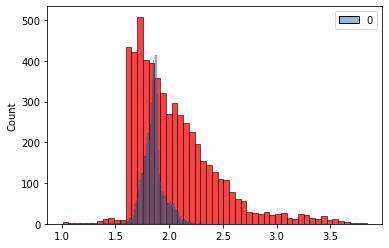

In [ ]:
fig, ax = plt.subplots()
g=sns.histplot(y_f[idx], ax=ax, color = 'r')
sns.histplot(model(X[idx]), ax=ax, color ='b')

<AxesSubplot: ylabel='Count'>

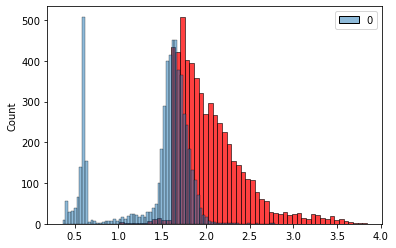

In [ ]:
fig, ax = plt.subplots()
g=sns.histplot(y_f[idx], ax=ax, color = 'r')
sns.histplot(model(X[idx]), ax=ax, color ='b')

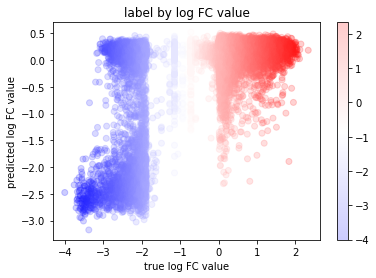

In [13]:
#Train samples classification results (TRAIN)
scatter_plots.Predicted_vs_actual_plot(y_f_train, model(X_train), y_f_train, "log FC" , "log FC", "log FC")

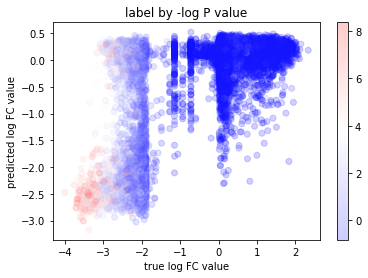

In [14]:
#Train samples classification results (TRAIN) 
scatter_plots.Predicted_vs_actual_plot(y_f_train, model(X_train), y_p_train, "log FC" , "log FC", "-log P")

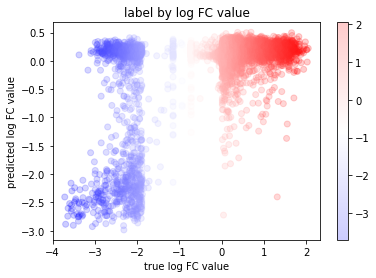

In [15]:
#Train samples classification results (TEST)
scatter_plots.Predicted_vs_actual_plot(y_f_test, model(X_test), y_f_test, "log FC" , "log FC", "log FC")

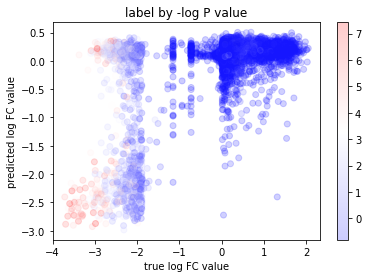

In [16]:
#Train samples classification results (TEST)
scatter_plots.Predicted_vs_actual_plot(y_f_test, model(X_test), y_p_test, "log FC" , "log FC", "-log P")

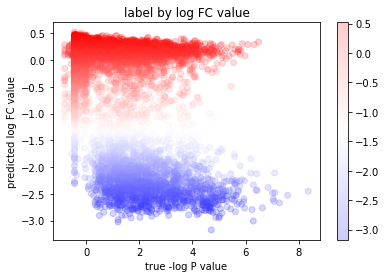

In [17]:
#Train samples classification results 
scatter_plots.Predicted_vs_actual_plot(y_p_train, model(X_train), model(X_train), "-log P" , "log FC", "log FC")

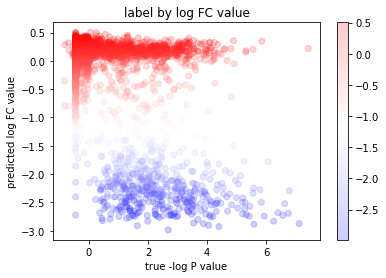

In [18]:
#Train samples classification results
scatter_plots.Predicted_vs_actual_plot(y_p_test, model(X_test), model(X_test), "-log P" , "log FC", "log FC")

In [19]:
# evaluate accuracy, precision, recall of trianed model
evaluation.single_regression_evaluation(y_f_train, model(X_train),y_f_cutoff)

4651 0 29680 2
accuracy 0.13552558762706435
precision 1.0
recall 6.738090425173506e-05


Text(0.5, 0, 'log_Fold')

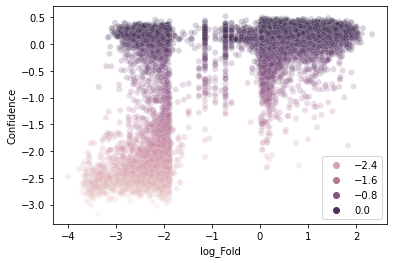

In [20]:
# confidence analysis
ax = sns.scatterplot(x=y_f_train, y=model(X_train).numpy().reshape(-1), hue=model(X_train).numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('log_Fold')

In [21]:
embedding=umap.embedding_regression(model,X_train)

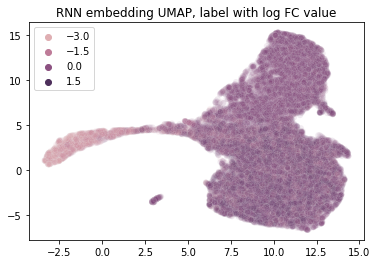

In [22]:
umap.UMAP_log_Fold(embedding, y_f_train)

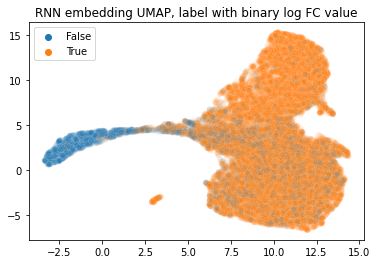

In [23]:
umap.UMAP_binary_log_Fold(embedding, y_f_train, y_f_cutoff)

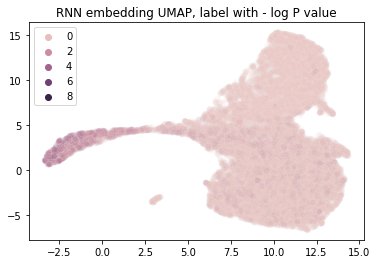

In [24]:
umap.UMAP_log_P(embedding, y_p_train)

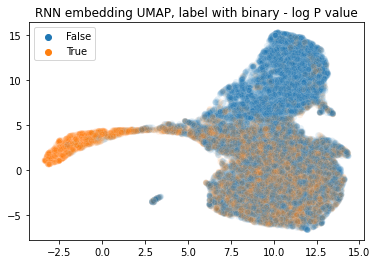

In [25]:
umap.UMAP_binary_log_P(embedding, y_p_train, y_p_cutoff)

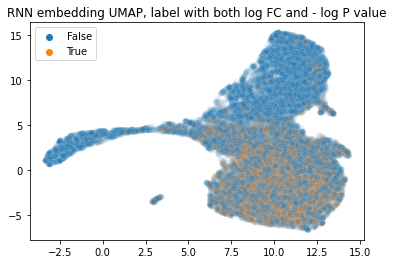

In [26]:
umap.UMAP_joint(embedding, y_f_train, y_f_cutoff, y_p_train, y_p_cutoff)

In [51]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] > y_f_cutoff:
        if y_p_train[i]> y_p_cutoff:
            if x1 >6:
                true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [52]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [53]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('CLG', 90),
 ('AYC', 91),
 ('ACR', 100),
 ('ECR', 100),
 ('DLR', 103),
 ('CGD', 106),
 ('AAC', 113),
 ('LGD', 115),
 ('YAA', 116),
 ('RDY', 125),
 ('LEC', 135),
 ('DYS', 169),
 ('YAC', 332),
 ('GDY', 579),
 ('DYA', 615)]

In [54]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('DYA', 615)
('GDY', 579)
('YAC', 332)
('DYS', 169)
('LEC', 135)


In [ ]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "12ca5"
other_protein = "MDM2"
# other_protein = "mCDH2"
X, y = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

 - log P value cutoff is -0.4463856871323837, and log FC value cutoff is 0.6565247891915524


Epoch 1/20
186/186 [==============================] - 7s 37ms/step - loss: 0.8466 - fold_rmse: 0.8506 - accuracy: 0.0000e+00 - val_loss: 1.0072 - val_fold_rmse: 1.0034 - val_accuracy: 0.0000e+00 - lr: 2.2313e-04
Epoch 2/20
186/186 [==============================] - 7s 40ms/step - loss: 0.7423 - fold_rmse: 0.7422 - accuracy: 0.0000e+00 - val_loss: 0.9118 - val_fold_rmse: 0.9072 - val_accuracy: 0.0000e+00 - lr: 2.2313e-04
Epoch 3/20
186/186 [==============================] - 7s 39ms/step - loss: 0.7253 - fold_rmse: 0.7272 - accuracy: 0.0000e+00 - val_loss: 0.7611 - val_fold_rmse: 0.7553 - val_accuracy: 0.0000e+00 - lr: 2.2313e-04
Epoch 4/20
186/186 [==============================] - 7s 36ms/step - loss: 0.7191 - fold_rmse: 0.7192 - accuracy: 0.0000e+00 - val_loss: 0.6938 - val_fold_rmse: 0.6870 - val_accuracy: 0.0000e+00 - lr: 2.2313e-04
Epoch 5/20
186/186 [==============================] - 7s 37ms/step - loss: 0.7105 - fold_rmse: 0.7085 - accuracy: 0.0000e+00 - val_loss: 0.6850 - val_fo

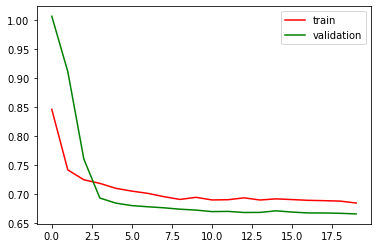

In [ ]:
y_f = y[:,1]
y_p = y[:,0]

result2 = experiment.SingleRegressionExperiment().run_adhoc_experiment(
    X, y, rnn.SingleRegression_CNNRNN, exp_name='SingleRegression_CNNRNN_Dense16_epoch20_12ca5_vs_mdm2'
)

In [ ]:
# import os
# import pickle
# exp_name = 'SingleRegressionRNN_2LSTM_Dense32_epoch10'
# exp_dir = os.path.join('experiments', exp_name)
# os.makedirs(exp_dir, exist_ok=True)
# with open(os.path.join(exp_dir, 'history.pkl'), 'wb') as f:
#     pickle.dump(history.history, f)

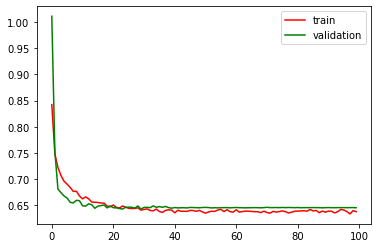

In [ ]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], color='r')
ax.plot(history.history['val_loss'], color='g')
ax.legend(['train', 'validation'])
fig.savefig(os.path.join(exp_dir, 'loss.png'))

In [ ]:
model =result2.trained_model

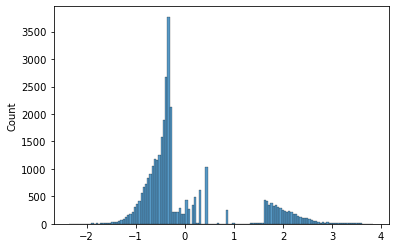

In [ ]:
g=sns.histplot(y_f)

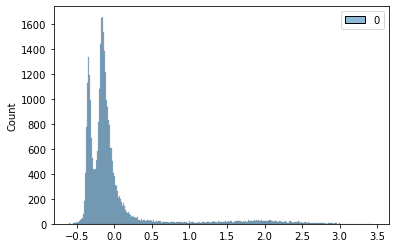

In [ ]:
g=sns.histplot(model(X))

<AxesSubplot: ylabel='Count'>

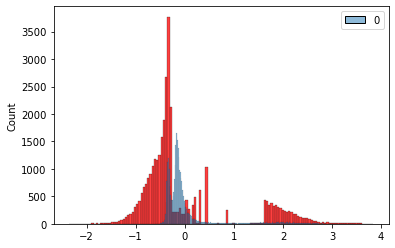

In [ ]:
fig, ax = plt.subplots()
sns.histplot(y_f, ax=ax, color = 'r')
sns.histplot(model(X), ax=ax, color ='b')

In [ ]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 0, X, y)

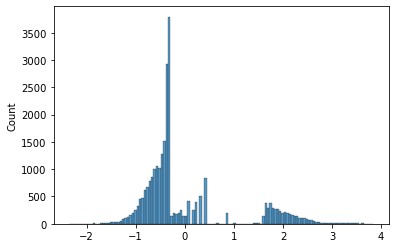

In [ ]:
g=sns.histplot(y_f_train)

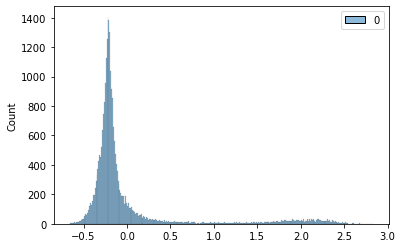

In [ ]:
g=sns.histplot(model(X_train))

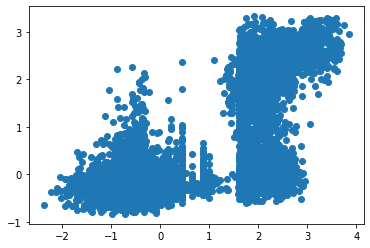

In [ ]:
g=plt.scatter(y_f,model(X))

<AxesSubplot: ylabel='Count'>

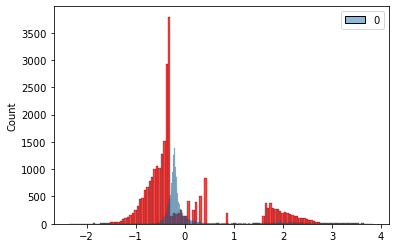

In [ ]:
fig, ax = plt.subplots()
sns.histplot(y_f_train, ax=ax, color = 'r')
sns.histplot(model(X_train), ax=ax, color ='b')

NameError: name 'idx' is not defined

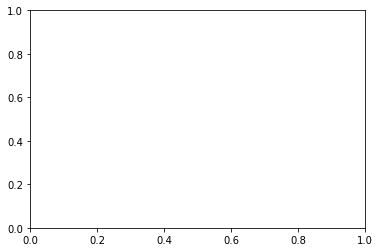

In [ ]:
fig, ax = plt.subplots()
g=sns.histplot(y_f[idx], ax=ax, color = 'r')
sns.histplot(model(X[idx]), ax=ax, color ='b')

<AxesSubplot: ylabel='Count'>

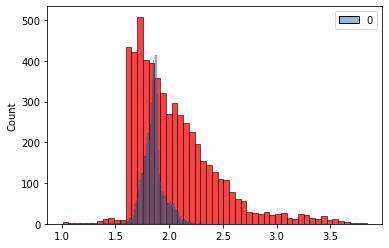

In [ ]:
fig, ax = plt.subplots()
g=sns.histplot(y_f[idx], ax=ax, color = 'r')
sns.histplot(model(X[idx]), ax=ax, color ='b')

<AxesSubplot: ylabel='Count'>

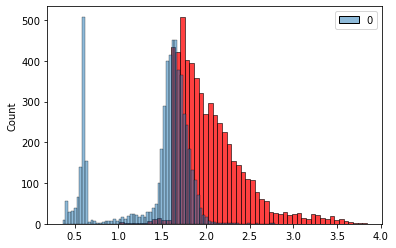

In [ ]:
fig, ax = plt.subplots()
g=sns.histplot(y_f[idx], ax=ax, color = 'r')
sns.histplot(model(X[idx]), ax=ax, color ='b')

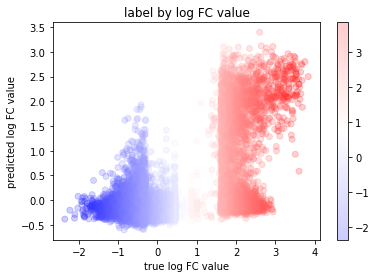

In [ ]:
#Train samples classification results (TRAIN)
scatter_plots.Predicted_vs_actual_plot(y_f_train, model(X_train), y_f_train, "log FC" , "log FC", "log FC")

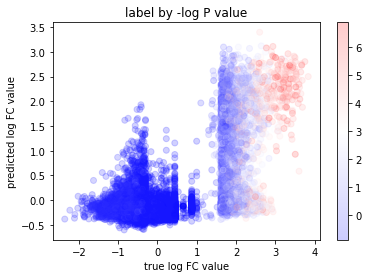

In [ ]:
#Train samples classification results (TRAIN) 
scatter_plots.Predicted_vs_actual_plot(y_f_train, model(X_train), y_p_train, "log FC" , "log FC", "-log P")

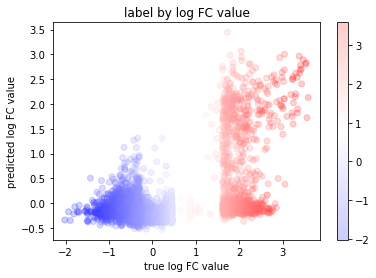

In [ ]:
#Train samples classification results (TEST)
scatter_plots.Predicted_vs_actual_plot(y_f_test, model(X_test), y_f_test, "log FC" , "log FC", "log FC")

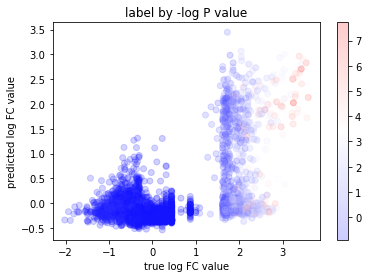

In [ ]:
#Train samples classification results (TEST)
scatter_plots.Predicted_vs_actual_plot(y_f_test, model(X_test), y_p_test, "log FC" , "log FC", "-log P")

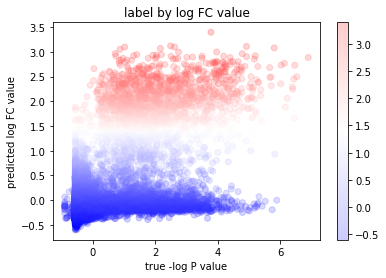

In [ ]:
#Train samples classification results 
scatter_plots.Predicted_vs_actual_plot(y_p_train, model(X_train), model(X_train), "-log P" , "log FC", "log FC")

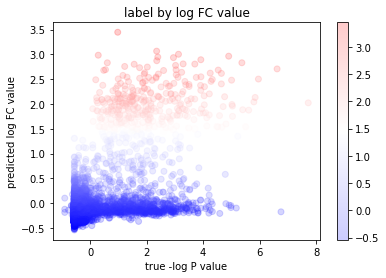

In [ ]:
#Train samples classification results
scatter_plots.Predicted_vs_actual_plot(y_p_test, model(X_test), model(X_test), "-log P" , "log FC", "log FC")

In [ ]:
# evaluate accuracy, precision, recall of trianed model
evaluation.single_regression_evaluation(y_f_train, model(X_train),y_f_cutoff)

21407 228 2694 1999
accuracy 0.8890154968094804
precision 0.8976201167489897
recall 0.42595354783720435


Text(0.5, 0, 'log_Fold')

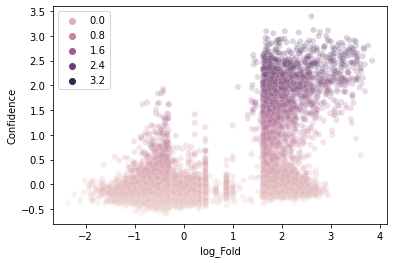

In [ ]:
# confidence analysis
ax = sns.scatterplot(x=y_f_train, y=model(X_train).numpy().reshape(-1), hue=model(X_train).numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('log_Fold')

In [ ]:
embedding=umap.embedding_regression(model,X_train)

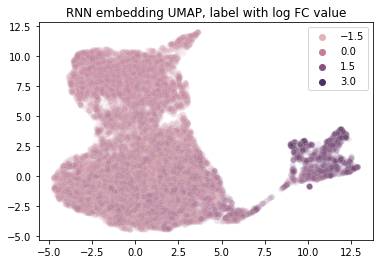

In [ ]:
umap.UMAP_log_Fold(embedding, y_f_train)

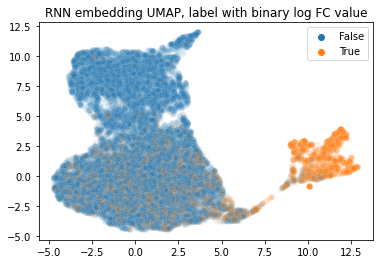

In [ ]:
umap.UMAP_binary_log_Fold(embedding, y_f_train, y_f_cutoff)

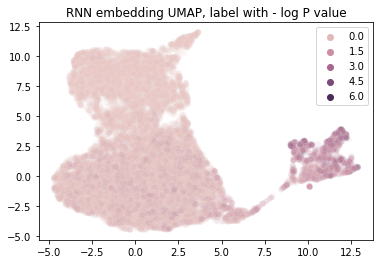

In [ ]:
umap.UMAP_log_P(embedding, y_p_train)

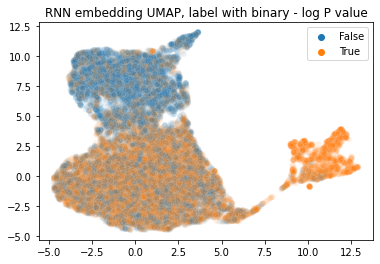

In [ ]:
umap.UMAP_binary_log_P(embedding, y_p_train, y_p_cutoff)

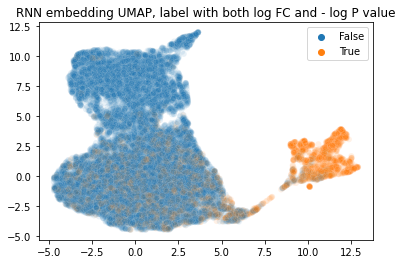

In [ ]:
umap.UMAP_joint(embedding, y_f_train, y_f_cutoff, y_p_train, y_p_cutoff)

In [ ]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] > y_f_cutoff:
        if y_p_train[i]> y_p_cutoff:
            if x1 >6:
                true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [ ]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [ ]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('PDY', 96),
 ('ACR', 106),
 ('ECR', 106),
 ('AVC', 107),
 ('DLR', 108),
 ('CGD', 115),
 ('RDY', 132),
 ('LGD', 133),
 ('YAA', 137),
 ('AAC', 141),
 ('DYS', 170),
 ('LEC', 171),
 ('YAC', 326),
 ('GDY', 582),
 ('DYA', 624)]

In [ ]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('DYA', 624)
('GDY', 582)
('YAC', 326)
('LEC', 171)
('DYS', 170)


In [57]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "MDM2"
other_protein = "mCDH2"
# other_protein = "mCDH2"
X, y = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

 - log P value cutoff is -0.08396512191297816, and log FC value cutoff is 0.2554564033078139


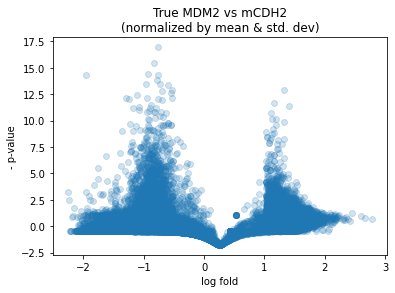

In [58]:
import matplotlib.pyplot as plt

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], y[:, 0], alpha=0.2)
    plt.show()

show_volcano(
    y, protein_of_interest, other_protein, title_addendum="True "
)

2023-01-11 07:27:58.195558: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
332/332 [==============================] - 14s 41ms/step - loss: 0.9888 - fold_rmse: 0.9886 - accuracy: 0.0000e+00 - val_loss: 0.9117 - val_fold_rmse: 0.9123 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/20
332/332 [==============================] - 12s 37ms/step - loss: 0.9821 - fold_rmse: 0.9821 - accuracy: 0.0000e+00 - val_loss: 0.8985 - val_fold_rmse: 0.8990 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/20
332/332 [==============================] - 12s 36ms/step - loss: 0.9798 - fold_rmse: 0.9798 - accuracy: 0.0000e+00 - val_loss: 0.8999 - val_fold_rmse: 0.9005 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/20
332/332 [==============================] - 12s 35ms/step - loss: 0.9777 - fold_rmse: 0.9778 - accuracy: 0.0000e+00 - val_loss: 0.8968 - val_fold_rmse: 0.8973 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/20
332/332 [==============================] - 13s 38ms/step - loss: 0.9772 - fold_rmse: 0.9771 - accuracy: 0.0000e+00 - val_loss: 0.8966 - val_fold_rmse: 0.

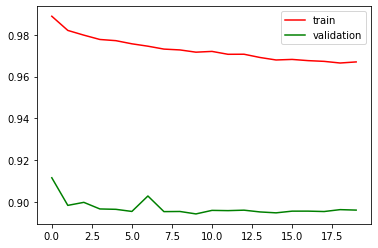

In [4]:
y_f = y[:,1]
y_p = y[:,0]

result2 = experiment.SingleRegressionExperiment().run_adhoc_experiment(
    X, y, rnn.SingleRegression_CNNRNN, exp_name='SingleRegression_CNNRNN_Dense16_epoch20_mdm2_vs_mCDH2'
)

In [22]:
y_p_cutoff=-0.08396512191297816
y_f_cutoff=0.2554564033078139

In [ ]:
# import os
# import pickle
# exp_name = 'SingleRegressionRNN_2LSTM_Dense32_epoch10'
# exp_dir = os.path.join('experiments', exp_name)
# os.makedirs(exp_dir, exist_ok=True)
# with open(os.path.join(exp_dir, 'history.pkl'), 'wb') as f:
#     pickle.dump(history.history, f)

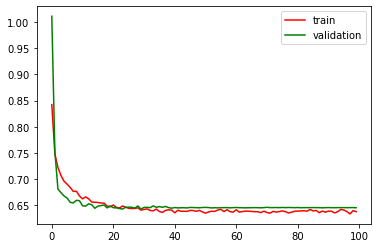

In [ ]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], color='r')
ax.plot(history.history['val_loss'], color='g')
ax.legend(['train', 'validation'])
fig.savefig(os.path.join(exp_dir, 'loss.png'))

In [5]:
model =result2.trained_model

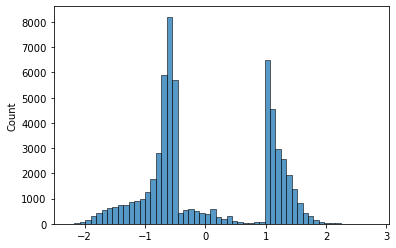

In [6]:
g=sns.histplot(y_f)

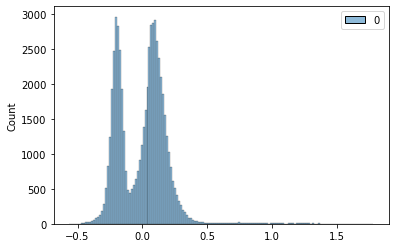

In [7]:
g=sns.histplot(model(X))

<AxesSubplot: ylabel='Count'>

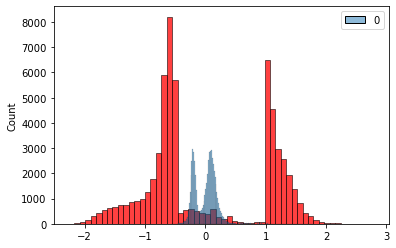

In [8]:
fig, ax = plt.subplots()
sns.histplot(y_f, ax=ax, color = 'r')
sns.histplot(model(X), ax=ax, color ='b')

In [9]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 0, X, y)

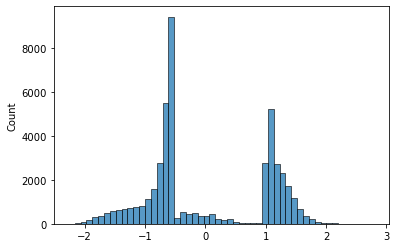

In [10]:
g=sns.histplot(y_f_train)

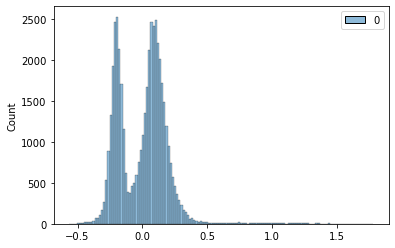

In [11]:
g=sns.histplot(model(X_train))

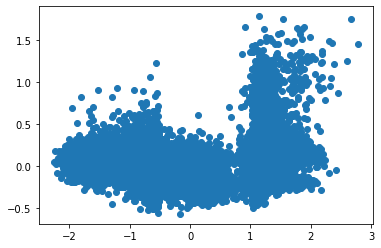

In [12]:
g=plt.scatter(y_f,model(X))

<AxesSubplot: ylabel='Count'>

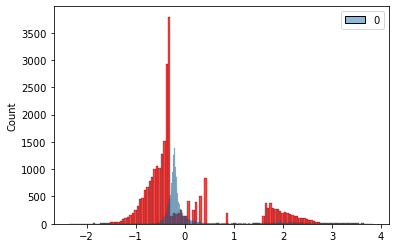

In [ ]:
fig, ax = plt.subplots()
sns.histplot(y_f_train, ax=ax, color = 'r')
sns.histplot(model(X_train), ax=ax, color ='b')

NameError: name 'idx' is not defined

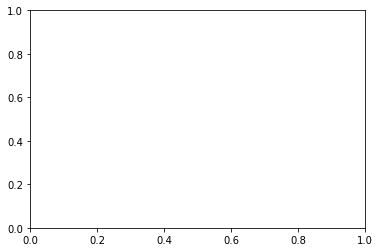

In [ ]:
fig, ax = plt.subplots()
g=sns.histplot(y_f[idx], ax=ax, color = 'r')
sns.histplot(model(X[idx]), ax=ax, color ='b')

<AxesSubplot: ylabel='Count'>

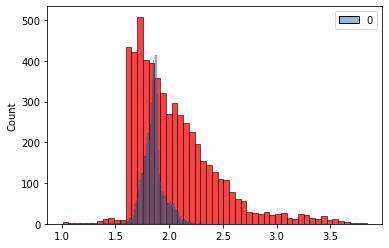

In [ ]:
fig, ax = plt.subplots()
g=sns.histplot(y_f[idx], ax=ax, color = 'r')
sns.histplot(model(X[idx]), ax=ax, color ='b')

<AxesSubplot: ylabel='Count'>

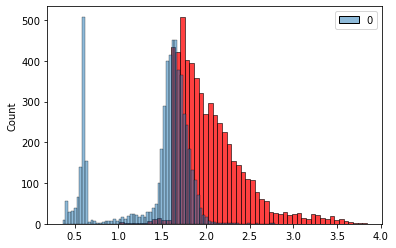

In [ ]:
fig, ax = plt.subplots()
g=sns.histplot(y_f[idx], ax=ax, color = 'r')
sns.histplot(model(X[idx]), ax=ax, color ='b')

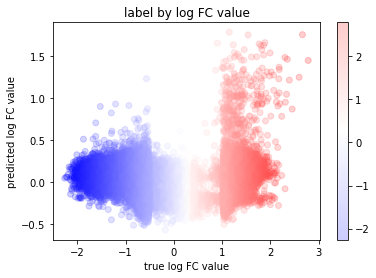

In [13]:
#Train samples classification results (TRAIN)
scatter_plots.Predicted_vs_actual_plot(y_f_train, model(X_train), y_f_train, "log FC" , "log FC", "log FC")

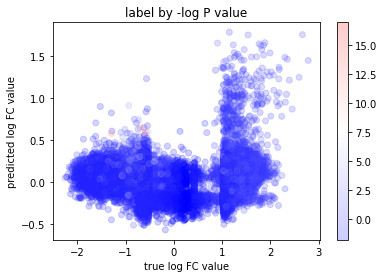

In [14]:
#Train samples classification results (TRAIN) 
scatter_plots.Predicted_vs_actual_plot(y_f_train, model(X_train), y_p_train, "log FC" , "log FC", "-log P")

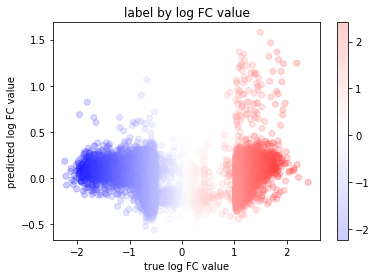

In [15]:
#Train samples classification results (TEST)
scatter_plots.Predicted_vs_actual_plot(y_f_test, model(X_test), y_f_test, "log FC" , "log FC", "log FC")

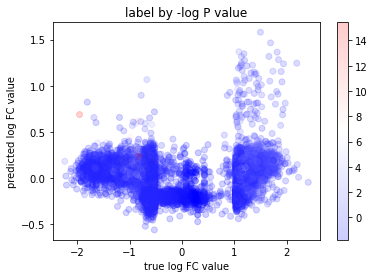

In [16]:
#Train samples classification results (TEST)
scatter_plots.Predicted_vs_actual_plot(y_f_test, model(X_test), y_p_test, "log FC" , "log FC", "-log P")

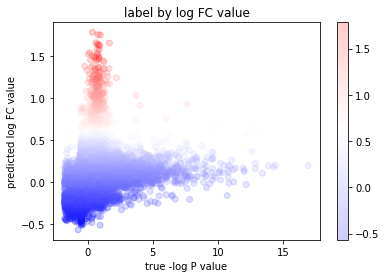

In [17]:
#Train samples classification results 
scatter_plots.Predicted_vs_actual_plot(y_p_train, model(X_train), model(X_train), "-log P" , "log FC", "log FC")

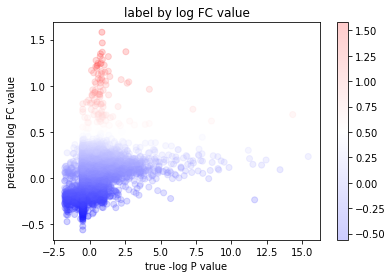

In [18]:
#Train samples classification results
scatter_plots.Predicted_vs_actual_plot(y_p_test, model(X_test), model(X_test), "-log P" , "log FC", "log FC")

In [ ]:
# evaluate accuracy, precision, recall of trianed model
evaluation.single_regression_evaluation(y_f_train, model(X_train),y_f_cutoff)

21407 228 2694 1999
accuracy 0.8890154968094804
precision 0.8976201167489897
recall 0.42595354783720435


Text(0.5, 0, 'log_Fold')

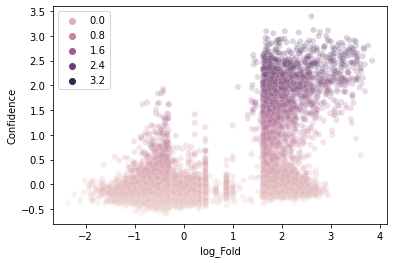

In [ ]:
# confidence analysis
ax = sns.scatterplot(x=y_f_train, y=model(X_train).numpy().reshape(-1), hue=model(X_train).numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('log_Fold')

In [19]:
embedding=umap.embedding_regression(model,X_train)

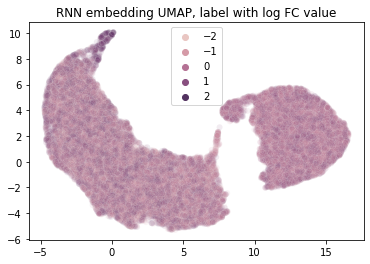

In [20]:
umap.UMAP_log_Fold(embedding, y_f_train)

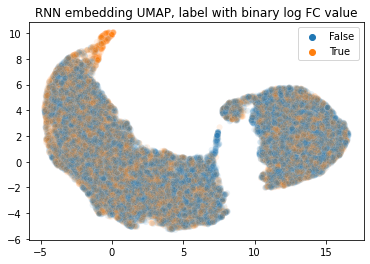

In [23]:
umap.UMAP_binary_log_Fold(embedding, y_f_train, y_f_cutoff)

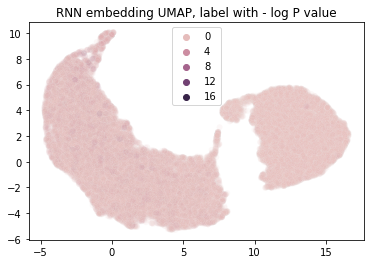

In [24]:
umap.UMAP_log_P(embedding, y_p_train)

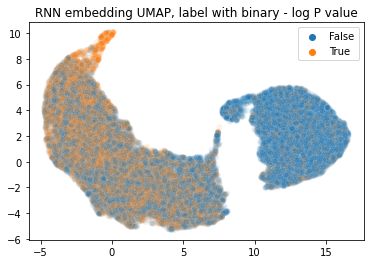

In [25]:
umap.UMAP_binary_log_P(embedding, y_p_train, y_p_cutoff)

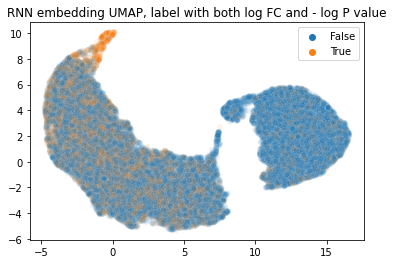

In [26]:
umap.UMAP_joint(embedding, y_f_train, y_f_cutoff, y_p_train, y_p_cutoff)

In [27]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] > y_f_cutoff:
        if y_p_train[i]> y_p_cutoff:
            if x2 >8:
                true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [28]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [31]:
ninemer_seq

['CERFWCNG',
 'FCDWYWCA',
 'FCDGLWCS',
 'CVNWSSCV',
 'FCDLLWCS',
 'FCEWLWCS',
 'CSTFECWW',
 'FGDWFWCS',
 'CEYFSCWW',
 'CTTFMCWW',
 'FWDWFWCA',
 'FCVWFWRS',
 'FCYFFWCS',
 'FCSWFWCS',
 'FCDWLWCA',
 'FWDWLWCS',
 'CYTFACFW',
 'FCDWFECF',
 'YCVWFWCS',
 'CEGYFRCH',
 'FKTFMCWW',
 'CKTSMCWW',
 'FCYWFWCY',
 'FRDWFWCS',
 'LCGLWCHK',
 'FCDWFEYN',
 'CTNFECWW',
 'FCDWFWCP',
 'FCYWFWCA',
 'FCDGFWCS',
 'CKSFMCWW',
 'CKCFMCWW',
 'FCVLFWCS',
 'YCDWVWCS',
 'FCAWFWCS',
 'CESFSCWR',
 'CVSFSCWW',
 'FCEWFWCC',
 'FCDLFWCA',
 'FCAGFWCS',
 'FCPFSFCR',
 'FCDWFLCS',
 'CSSFECFL',
 'FCDCFCCS',
 'FCEWFWCA',
 'FCVWLWCA',
 'CSLRSCVK',
 'CESFKCMV',
 'FCVWSWCS',
 'CETFACWR',
 'FCFWLWCS',
 'FCDWFACN',
 'FCDWCWCA',
 'FCVWLECN',
 'LCVWVWCS',
 'FCDWFRCS',
 'FCVWVLCS',
 'CNTFMCLW',
 'FCVWFWWS',
 'FCDWFEGN',
 'FCVWFCCS',
 'FCVWFECY',
 'FCDWFWCS',
 'CSGFRCFV',
 'FCDLFWFS',
 'CKTFMCWG',
 'FCPWWCSL',
 'CSSFECWW',
 'CETVACWW',
 'FSDWYWCS',
 'FCDCVWCS',
 'FCDWFDCN',
 'FSDWFWCS',
 'VCVWFWCS',
 'FCAWFECN',
 'CLTFMCWW',
 'FCDWFWCA',

In [29]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('CFW', 23),
 ('ACK', 27),
 ('FMC', 32),
 ('MCW', 32),
 ('FCV', 36),
 ('CVW', 40),
 ('FEC', 41),
 ('CWW', 50),
 ('WFW', 63),
 ('DWF', 66),
 ('FWC', 75),
 ('WCS', 91),
 ('CDW', 96),
 ('FCD', 108),
 ('AFC', 192)]

In [30]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('AFC', 192)
('FCD', 108)
('CDW', 96)
('WCS', 91)
('FWC', 75)


In [2]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "12ca5"
other_protein = "MDM2"
X, y = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

 - log P value cutoff is -0.4463856871323837, and log FC value cutoff is 0.6565247891915524


In [3]:
result = experiment.RegressionExperiment().run_adhoc_experiment(
    X, y, rnn.RegressionRNN, load_trained_model=False
)

Epoch 1/50


2023-01-09 05:38:52.735829: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


186/186 [==============================] - 17s 88ms/step - loss: 0.7790 - mse: 0.7790 - val_loss: 0.6682 - val_mse: 0.6682 - lr: 0.0100
Epoch 2/50
186/186 [==============================] - 16s 86ms/step - loss: 0.6842 - mse: 0.6842 - val_loss: 0.6720 - val_mse: 0.6720 - lr: 0.0100
Epoch 3/50
186/186 [==============================] - 17s 92ms/step - loss: 0.6549 - mse: 0.6549 - val_loss: 0.6517 - val_mse: 0.6517 - lr: 0.0100
Epoch 4/50
186/186 [==============================] - 16s 87ms/step - loss: 0.6492 - mse: 0.6492 - val_loss: 0.6913 - val_mse: 0.6913 - lr: 0.0100
Epoch 5/50
186/186 [==============================] - 17s 92ms/step - loss: 0.6561 - mse: 0.6561 - val_loss: 0.6419 - val_mse: 0.6419 - lr: 0.0100
Epoch 6/50
186/186 [==============================] - 17s 89ms/step - loss: 0.6323 - mse: 0.6323 - val_loss: 0.6440 - val_mse: 0.6440 - lr: 0.0090
Epoch 7/50
186/186 [==============================] - 17s 89ms/step - loss: 0.6283 - mse: 0.6283 - val_loss: 0.6552 - val_mse: 0.

In [4]:
y_f_cutoff = 0.6565247891915524
y_p_cutoff = -0.4463856871323837

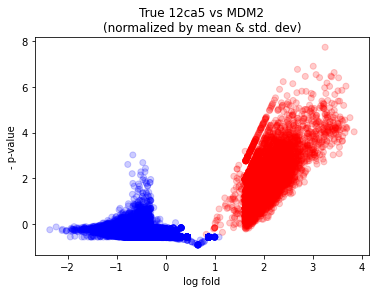

In [5]:
import matplotlib.pyplot as plt

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], y[:, 0], c =(y[:, 0]>y_p_cutoff)*(y[:, 1]>y_f_cutoff), cmap='bwr',alpha=0.2)
    plt.show()

show_volcano(
    y, protein_of_interest, other_protein, title_addendum="True "
)

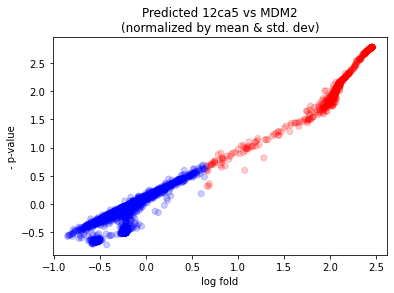

In [7]:
show_volcano(
    np.array(result.y_pred), protein_of_interest, other_protein, title_addendum="Predicted "
)

In [8]:
model =result.trained_model

In [9]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 0, X, y)

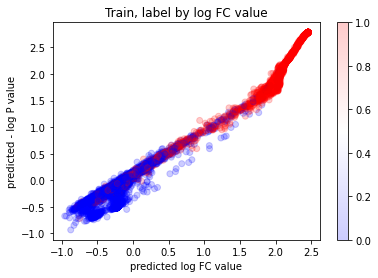

In [10]:
#Train samples classification results 
plt.ylabel("predicted - log P value")
plt.xlabel("predicted log FC value")
plt.scatter(model(X_train)[:,1], model(X_train)[:,0], c=y_f_train> y_f_cutoff, cmap='bwr',alpha=0.2)
plt.title("Train, label by log FC value")
plt.colorbar()
plt.show()

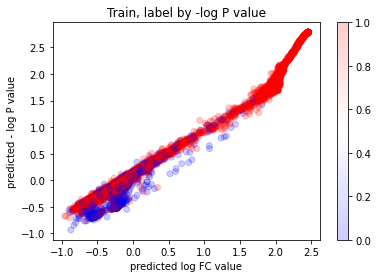

In [11]:
#Train samples classification results 
plt.ylabel("predicted - log P value")
plt.xlabel("predicted log FC value")
plt.scatter(model(X_train)[:,1], model(X_train)[:,0], c=y_p_train>y_p_cutoff, cmap='bwr',alpha=0.2)
plt.title("Train, label by -log P value")
plt.colorbar()
plt.show()

Text(0.5, 0, 'log_Fold')

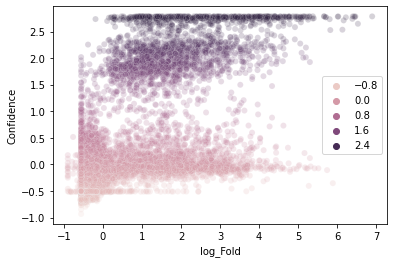

In [12]:
# confidence analysis
ax = sns.scatterplot(x=y_p_train, y=model(X_train)[:,0].numpy().reshape(-1), hue=model(X_train)[:,0].numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('log_Fold')

Text(0.5, 0, 'log_Fold')

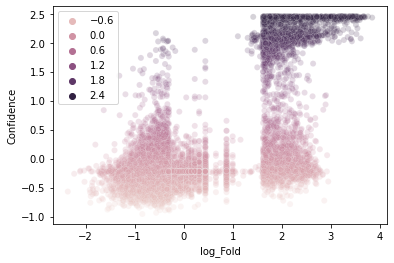

In [13]:
# confidence analysis
ax = sns.scatterplot(x=y_f_train, y=model(X_train)[:,1].numpy().reshape(-1), hue=model(X_train)[:,1].numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('log_Fold')

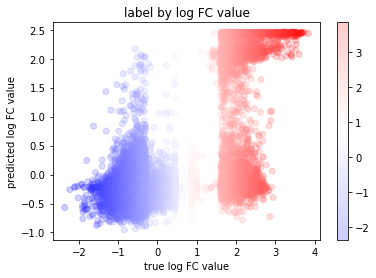

In [19]:
#Train samples classification results (TRAIN)
scatter_plots.Predicted_vs_actual_plot(y_f_train, model(X_train)[:,1], y_f_train, "log FC" , "log FC", "log FC")

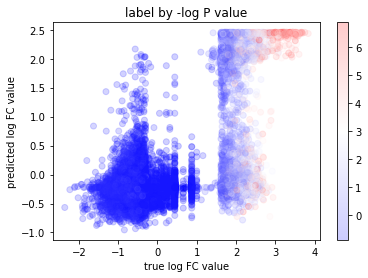

In [20]:
#Train samples classification results (TRAIN) 
scatter_plots.Predicted_vs_actual_plot(y_f_train, model(X_train)[:,1], y_p_train, "log FC" , "log FC", "-log P")

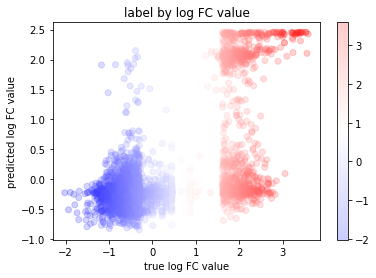

In [21]:
#Train samples classification results (TEST)
scatter_plots.Predicted_vs_actual_plot(y_f_test, model(X_test)[:,1], y_f_test, "log FC" , "log FC", "log FC")

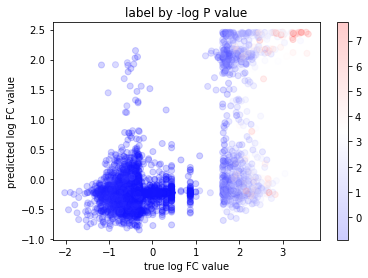

In [22]:
#Train samples classification results (TEST)
scatter_plots.Predicted_vs_actual_plot(y_f_test, model(X_test)[:,1], y_p_test, "log FC" , "log FC", "-log P")

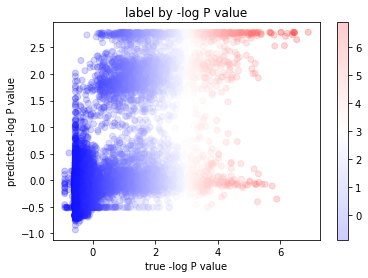

In [23]:
#Train samples classification results 
scatter_plots.Predicted_vs_actual_plot(y_p_train, model(X_train)[:,0], y_p_train, "-log P" , "-log P", "-log P")

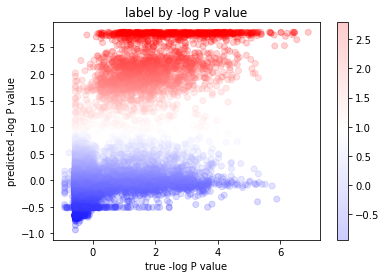

In [24]:
#Train samples classification results 
scatter_plots.Predicted_vs_actual_plot(y_p_train, model(X_train)[:,0],model(X_train)[:,0], "-log P" , "-log P", "-log P")

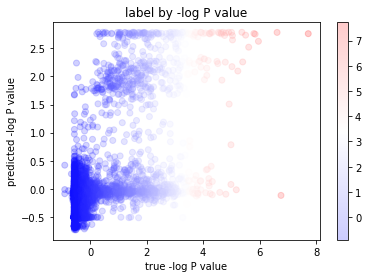

In [25]:
#Train samples classification results 
scatter_plots.Predicted_vs_actual_plot(y_p_test, model(X_test)[:,0], y_p_test, "-log P" , "-log P", "-log P")

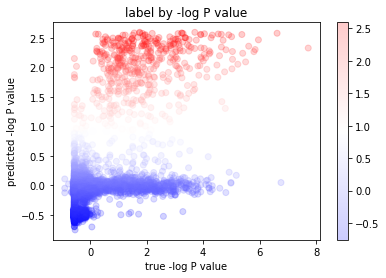

In [20]:
#Train samples classification results 
scatter_plots.Predicted_vs_actual_plot(y_p_test, model(X_test)[:,0], model(X_test)[:,0], "-log P" , "-log P", "-log P")

In [26]:
# evaluate accuracy, precision, recall of trianed model
evaluation.single_regression_evaluation(y_f_train, np.array(model(X_train)[:,1]), y_f_cutoff)

21443 192 2381 2312
accuracy 0.9022713460954117
precision 0.9233226837060703
recall 0.4926486256126145


In [27]:
# evaluate accuracy, precision, recall of trianed model
evaluation.joint_regression_evaluation(y_f_train, np.array(model(X_train)[:,1]), y_f_cutoff,y_p_train, np.array(model(X_train)[:,0]), y_p_cutoff )

21674 182 2165 2307
accuracy 0.9108553631115163
precision 0.9268782643631981
recall 0.5158765652951699


In [23]:
embedding=umap.embedding_classification(model,X_train)

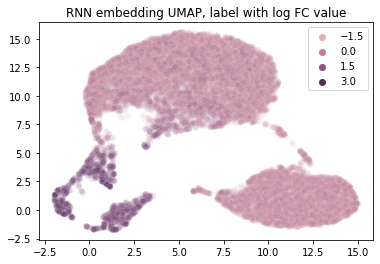

In [24]:
umap.UMAP_log_Fold(embedding, y_f_train)

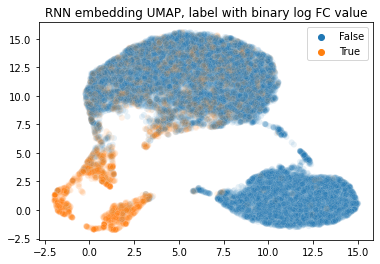

In [25]:
umap.UMAP_binary_log_Fold(embedding, y_f_train, y_f_cutoff)

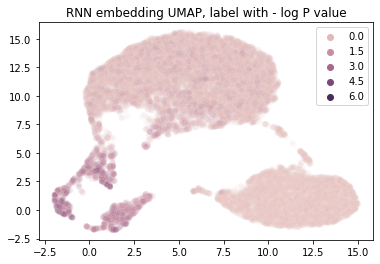

In [26]:
umap.UMAP_log_P(embedding, y_p_train)

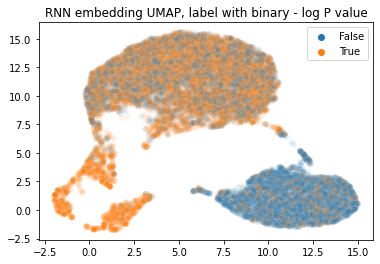

In [27]:
umap.UMAP_binary_log_P(embedding, y_p_train, y_p_cutoff)

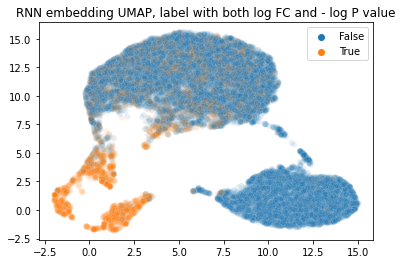

In [28]:
umap.UMAP_joint(embedding,y_f_train, y_f_cutoff, y_p_train,y_p_cutoff)

In [29]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i]>y_f_cutoff:
        if y_p_train[i]> y_p_cutoff:
            if x2 <4.0:
                true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [30]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [31]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('EDL', 91),
 ('LRD', 93),
 ('ECR', 94),
 ('PDY', 96),
 ('DLR', 108),
 ('CGD', 109),
 ('AAC', 111),
 ('LGD', 121),
 ('YAA', 124),
 ('RDY', 128),
 ('LEC', 128),
 ('DYS', 163),
 ('YAC', 291),
 ('GDY', 571),
 ('DYA', 596)]

In [32]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('DYA', 596)
('GDY', 571)
('YAC', 291)
('DYS', 163)
('LEC', 128)


In [11]:
# Load other data libraries 
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
R2_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R2.csv")
R1_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R1.csv")

ImportError: cannot import name 'two_channel_mse' from 'models.rnn' (/Users/yitongtseo/Documents/GitHub/ml_phage_display/./src/models/rnn.py)

<AxesSubplot: xlabel='c_cnt', ylabel='Count'>

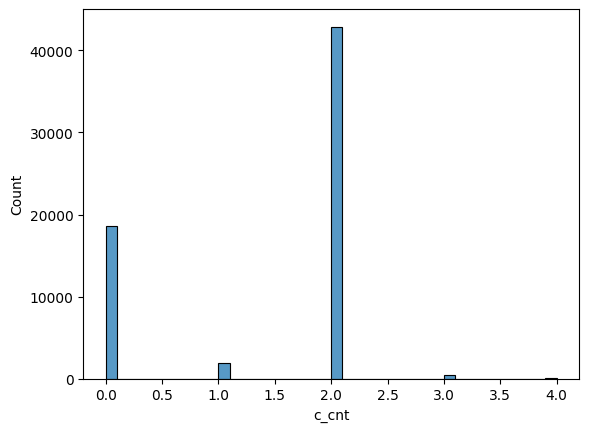

In [9]:
import seaborn as sns
sns.histplot(R3_lib['c_cnt'])

In [10]:
log_ratio_12ca5, _ = data_loading.build_dataset(R3_lib, protein_of_interest='12ca5')
sns.histplot(log_ratio_12ca5[R3_lib.is_dya==True], binwidth=0.2)
plt.title('DYA peptide')

IndexError: list index out of range

In [21]:
sns.histplot(log_ratio_12ca5[R3_lib.is_lle==True], binwidth=0.2, alpha=0.5)
plt.title('LLE peptide')

KeyError: '12ca5_log_ratio'

In [22]:
print((R3_lib.loc[R3_lib.is_lle==True]['12ca5_log_ratio']>0).sum())
print((R3_lib.loc[R3_lib.is_lle==True]['12ca5_log_ratio']<=0).sum())

KeyError: '12ca5_log_ratio'

Text(0.5, 1.0, 'all peptide')

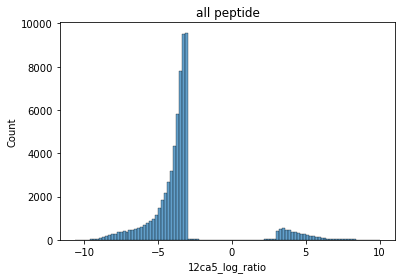

In [ ]:
sns.histplot(R3_lib['12ca5_log_ratio'], binwidth=0.2, alpha=0.7)
plt.title('all peptide')
# sns.histplot(R3_lib.loc[R3_lib.is_dya==True]['12ca5_log_ratio'], binwidth=0.2)

In [ ]:
print(acc)
print(pre)
print(rec)

[0.6483550832226304, 0.6542158318355865, 0.6634104407627384, 0.6598937167864958, 0.6517661769302907]
[0.6417112299465241, 0.6702702702702703, 0.6440677966101694, 0.7009803921568627, 0.751937984496124]
[0.026356248627278717, 0.027629233511586453, 0.026158788435061954, 0.03225078935498421, 0.021455430214554302]


In [ ]:
print(np.array(acc).mean(), np.array(acc).var())
print(np.array(pre).mean(), np.array(pre).var())
print(np.array(rec).mean(), np.array(rec).var())

0.6555282499075484 2.9703237664053927e-05
0.6817935346959902 0.0016901974856322836
0.026770098028693123 1.1913351182601678e-05


In [ ]:
# get the 4th fold because the 4th model showed the best precision
# actually unnecessary, can just use whatever fold
kf = KFold(n_splits=2)
i = 0
y_reg = np.array(list(y_reg))
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_reg_train, y_reg_test = y_reg[train_index], y_reg[test_index]
    if i==0:
        break
    i += 1

In [ ]:
embedding = reducer.fit_transform(nn_emb)

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

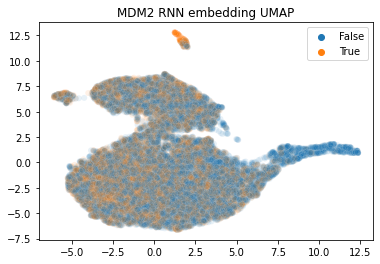

In [ ]:
# tests
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=y_train, alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

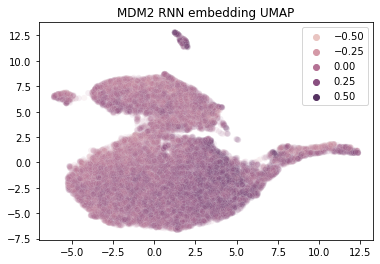

In [ ]:
# tests
X_train_prop1 = X_train[:,:,2].mean(-1)
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=X_train_prop1, alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

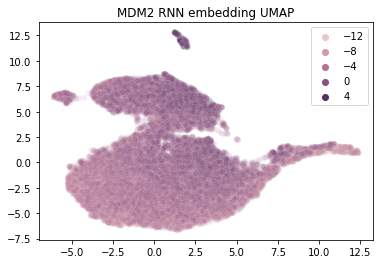

In [ ]:
# color by volume of side chain
X_train_prop2 = X_train[:,:,10].sum(-1)#.sum(-1)
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=X_train_prop2, alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

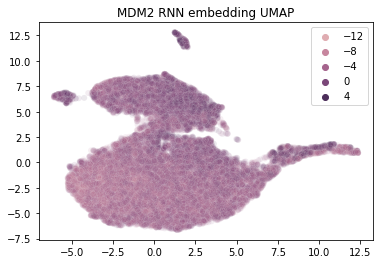

In [ ]:
# color by SASA
X_train_prop2 = X_train[:,:,9].sum(-1)#.sum(-1)
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=X_train_prop2, alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

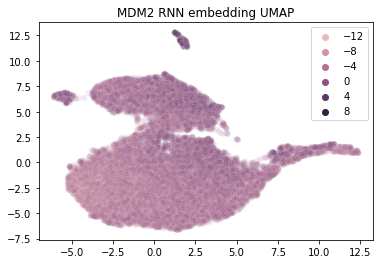

In [ ]:
# color by polarizability
X_train_prop2 = X_train[:,:,8].sum(-1)
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=X_train_prop2, alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

In [ ]:
# write results
with open('mdm2_good.txt','w') as fh:
    for i in range(len(ls)):
        fh.write(f'{ls[i]}\n')

In [ ]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_train[i] == 1:
        if x2 > 10.0:
            true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [ ]:
good_seqs

['AFCDWFACY',
 'ACKPFMCWW',
 'AFCDWFKCN',
 'AFCDWYCCS',
 'ACSCFECFW',
 'AYCVWVWCS',
 'AFCDWLWCS',
 'AFCDRFWCS',
 'AFCYWCWCS',
 'AFCDGLWCS',
 'WSLNSGMFGYQW',
 'AFCDCVWCS',
 'AFCDCFLCS',
 'AFWDWFWCA',
 'ACVSFECFW',
 'AFCDWYECN',
 'ALCGFWFCD',
 'AFCVWFECY',
 'AFFDWFWCS',
 'ACECFSCWW',
 'ACSTFECWW',
 'ACKCFMCWW',
 'AYCYWFWCS',
 'ACMTFMCWC',
 'ACCDWFWCS',
 'AFKTFMCWW',
 'AFCFWFWCS',
 'ACDSFSCWW',
 'AFCDYFYCS',
 'AVCFLEWCS',
 'ALCVWVWCS',
 'AFCWFDSCQ',
 'AFCYLFWCS',
 'AFCDLFWCD',
 'ACETFMCWW',
 'AFCDWLWCP',
 'AYCVWFWCS',
 'AYCDWFECN',
 'ACMTFMCWW',
 'ACSTFEWFW',
 'AFFDCFWCS',
 'AFFAWFWCS',
 'AFCAWFWWS',
 'ACKTFLCWW',
 'AFCVWVWCC',
 'ACKTFMFWW',
 'ACTTFEWWW',
 'AFCVWFLCC',
 'AFCDWFVCY',
 'AFCVWFWRS',
 'ACYTFMCWW',
 'AFCYWVWCS',
 'AFCDWYWCS',
 'AYCDWFECN',
 'AFCVWVWGS',
 'AFCAWFWCS',
 'AFCDWVWCS',
 'ACWWWSYCS',
 'AFCVWVWCS',
 'AFWVWFWCS',
 'AFCDWFESN',
 'AFCVRFWCS',
 'ACYTFMCWW',
 'AFCDGVWCS',
 'AFCYWLWCS',
 'ALCDWFWCS',
 'AFCVWFWCS',
 'AFCDWFECY',
 'ACSPFECFW',
 'AFFFWFWCS',
 'AFCDWSWCS',
 'A

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

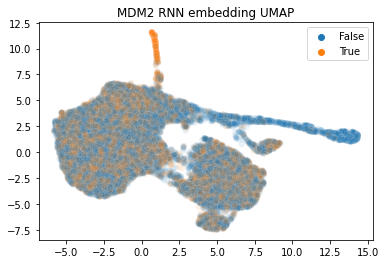

In [ ]:
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=y_train, alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

In [ ]:
y_pred = model(X_train)

Text(0.5, 0, 'MDM2_log_ratio')

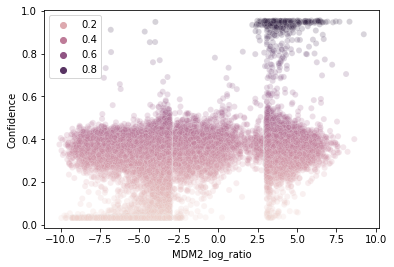

In [ ]:
# colored by predicted confidence
ax = sns.scatterplot(x=y_mdm2_reg_train, y=y_pred.numpy().reshape(-1), hue=y_pred.numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('MDM2_log_ratio')

Text(0.5, 0, 'MDM2_log_ratio')

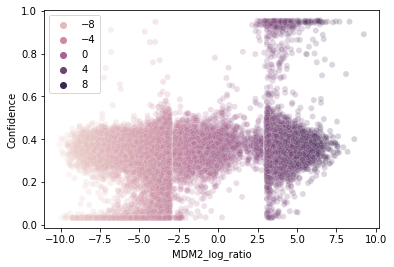

In [ ]:
# colored by true log ratio 
ax = sns.scatterplot(x=y_reg_train, y=y_pred.numpy().reshape(-1), hue=y_reg_train, alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('MDM2_log_ratio')

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

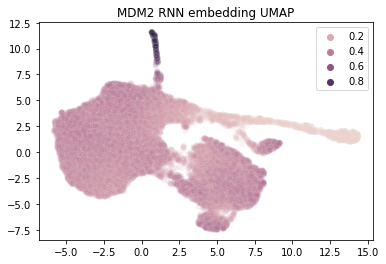

In [ ]:
# colored by predicted confidence
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=y_pred.numpy().reshape(-1), alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

In [ ]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_train[i] == 0:
        if x1 > 10.0:
            true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [ ]:
len(good_seqs)

1133

In [ ]:
good_seqs

['AVCGDYAEC',
 'KDVFRDY',
 'ACLGDYACR',
 'ACVGDYAAC',
 'DYPDYAD',
 'MADSPDY',
 'ACYGDYACF',
 'AGCGDYAAG',
 'DWGDYAL',
 'AHCYGDYAC',
 'DDYLDYS',
 'ACWDYACYV',
 'ACWEGEYAC',
 'KVELRDY',
 'AFCLGDYSC',
 'NEDLMDY',
 'AECGDYAEC',
 'AYCFGDYSC',
 'ACLGDYSHC',
 'ACFDADYSEC',
 'ADCYGDYAC',
 'AKCWGDYAC',
 'AQCFGDYAC',
 'ALCGDYSAC',
 'ACGDYAVVC',
 'ACVVDYACW',
 'ACMGDYASC',
 'KDDLWDY',
 'NEDLLYY',
 'TADMPDY',
 'ACYCDYACA',
 'MKDVVDY',
 'DARDYAG',
 'KEDLSYY',
 'AGWMTWCEE',
 'ACYVDYAAC',
 'ARCVGDYGC',
 'LMDWPDY',
 'AHCGDYAEC',
 'AVWWGDYAC',
 'ASCVGDYSC',
 'DEKDYAA',
 'KVDLGDF',
 'ACYGDYAGC',
 'DLYDYAH',
 'SEVYDYS',
 'ACAADLRDY',
 'AGCYGDYDC',
 'ADRRDYA',
 'ARCVGDYAF',
 'ATCVGDYAC',
 'DTMDYAY',
 'ACTGDYAWC',
 'ACNFDYACW',
 'ALCSGDYAC',
 'ACFADYACL',
 'ACNLPWCEE',
 'RLDKPDY',
 'LADLHDY',
 'AFCVGDYAC',
 'ACLGDYACK',
 'HAVGFDY',
 'AKCFGDYAW',
 'ACAADMRDY',
 'AHCDVMDYG',
 'AFCLGEYAC',
 'ACVGDYAGC',
 'AAWGDYAAC',
 'ACYGDYACY',
 'QHDYPDY',
 'SDTGDYA',
 'ACGMTWCEE',
 'ARCYGDYDC',
 'APCADYACW',
 'ACCFDLGDY',

In [ ]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [ ]:
for seq in ninemer_seq:
    print(seq)

VCGDYAEC
CLGDYACR
CVGDYAAC
CYGDYACF
GCGDYAAG
HCYGDYAC
CWDYACYV
CWEGEYAC
FCLGDYSC
ECGDYAEC
YCFGDYSC
CLGDYSHC
DCYGDYAC
KCWGDYAC
QCFGDYAC
LCGDYSAC
CGDYAVVC
CVVDYACW
CMGDYASC
CYCDYACA
GWMTWCEE
CYVDYAAC
RCVGDYGC
HCGDYAEC
VWWGDYAC
SCVGDYSC
CYGDYAGC
CAADLRDY
GCYGDYDC
RCVGDYAF
TCVGDYAC
CTGDYAWC
CNFDYACW
LCSGDYAC
CFADYACL
CNLPWCEE
FCVGDYAC
CLGDYACK
KCFGDYAW
CAADMRDY
HCDVMDYG
FCLGEYAC
CVGDYAGC
AWGDYAAC
CYGDYACY
CGMTWCEE
RCYGDYDC
PCADYACW
CCFDLGDY
CNGDYAAF
GGLGDYAR
GCWGDYAG
DCGGYCGY
VCWGDYEC
CPCDYAAC
RCAGDYAC
CVWRWCEE
LCQGDYAC
CRATWWEE
CVGDYACA
QCYGDYSC
CVFTFCEE
CWLTWCEE
PCGDYAAC
CLGYYAAC
YCVGDYAC
CVGDYACP
VCWGDYVC
RCWDYACY
ACFGDYAW
ACFGDYAF
CWWTWCEE
CCDYAAYC
CTGDYAAC
LCYGDYAC
CFGDYASC
VCGGDYAC
GCYGDYVC
CRGDFAAC
RCYWDYAC
GCVGDYAW
VCLGDYAG
HCGDYSAC
CPDYAACF
CWDGEYAC
CWMTWGEE
LCFCDYAC
MCWGDYAC
CFGYAAYC
LCFGDYAG
CPGDYSTC
MCYGDYSC
CYGDYASC
YCFGDYAW
CYGYYAAC
CAADRLDY
CSVDYAAC
CVGDYACS
LCGDYAAC
FCHGDYAF
GWLGDYAG
ACYGDYAC
CWMRWCEE
ECLGDYAR
CYFTWCEE
WRGDYAMC
CWLRWCEE
CYGDYACR
RCVGDYSC
CGDYSATC
GCYGDYEC
G

In [ ]:
y = R3_lib['12ca5_log_ratio']
y = np.array(list(y.apply(lambda e: e > 0)))
X, y = shuffle(nn_x, y, random_state=0)

In [ ]:
models = []
kf = KFold(n_splits=5)
acc, pre, rec = [], [], []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    model.fit(
        x=X_train,
        y=y_train,
        batch_size=128,
        epochs=16,
        verbose='auto',
        validation_split=0.1,
        initial_epoch=0,
        class_weight={1:0.8, 0:0.2},
        validation_freq=1,
        use_multiprocessing=False)
    
    y_pred = model(X_test)
    y_pred = y_pred.numpy().reshape(-1) >= 0.5
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    print(tn, fp, fn, tp)
    print("accuracy", (tn+tp)/(tn+fp+fn+tp))
    acc.append((tn+tp)/(tn+fp+fn+tp))
    print("precision", tp/(tp+fp))
    pre.append(tp/(tp+fp))
    print("recall", tp/(tp+fn))
    rec.append(tp/(tp+fn))
    models.append(model)

# do not trust the accuracy score here, it was wrongly implemented before (it's fine now)

Epoch 1/16
360/360 [==============================] - 7s 10ms/step - loss: 0.1145 - accuracy: 0.9132 - recall_6: 0.3721 - precision_6: 0.5076 - val_loss: 0.2706 - val_accuracy: 0.9271 - val_recall_6: 0.4262 - val_precision_6: 0.6788
Epoch 2/16
360/360 [==============================] - 3s 8ms/step - loss: 0.1006 - accuracy: 0.9287 - recall_6: 0.4497 - precision_6: 0.6320 - val_loss: 0.2840 - val_accuracy: 0.9265 - val_recall_6: 0.4699 - val_precision_6: 0.6513
Epoch 3/16
360/360 [==============================] - 3s 8ms/step - loss: 0.0973 - accuracy: 0.9339 - recall_6: 0.4536 - precision_6: 0.6873 - val_loss: 0.2818 - val_accuracy: 0.9269 - val_recall_6: 0.4719 - val_precision_6: 0.6542
Epoch 4/16
360/360 [==============================] - 3s 8ms/step - loss: 0.0956 - accuracy: 0.9372 - recall_6: 0.4606 - precision_6: 0.7238 - val_loss: 0.2607 - val_accuracy: 0.9375 - val_recall_6: 0.4699 - val_precision_6: 0.7766
Epoch 5/16
360/360 [==============================] - 3s 8ms/step - los

In [ ]:
kf = KFold(n_splits=5)
acc, pre, rec = [], [], []
i = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = models[i]
    y_pred = model(X_test)
    y_pred = y_pred.numpy().reshape(-1) >= 0.5
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(tn, fp, fn, tp)
    print("accuracy", (tn+tp)/(tn+fp+fn+tp))
    acc.append((tn+tp)/(tn+fp+fn+tp))
    print("precision", tp/(tp+fp))
    pre.append(tp/(tp+fp))
    print("recall", tp/(tp+fn))
    rec.append(tp/(tp+fn))
    
    i+=1
    if i==5:
        break

11626 85 592 494
accuracy 0.9470969758537157
precision 0.853195164075993
recall 0.4548802946593002
11468 173 602 554
accuracy 0.939438930999453
precision 0.7620357634112792
recall 0.47923875432525953
11493 200 597 506
accuracy 0.9377149109096593
precision 0.71671388101983
recall 0.4587488667271079
11566 72 638 520
accuracy 0.9445139105970616
precision 0.8783783783783784
recall 0.44905008635578586
11518 169 588 521
accuracy 0.9408408877774305
precision 0.755072463768116
recall 0.4697926059513075


In [ ]:
print(np.array(acc).mean(), np.array(acc).var())
print(np.array(pre).mean(), np.array(pre).var())
print(np.array(rec).mean(), np.array(rec).var())

0.9419211232274639 1.170648113987608e-05
0.7930791301307194 0.003825949573193828
0.46234212160375215 0.00011725489146586728


Text(0.5, 0, '12ca5_log_ratio')

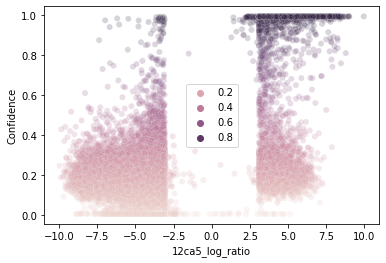

In [ ]:
# confidence analysis
ax = sns.scatterplot(x=y_12ca5_reg_train, y=y_pred.numpy().reshape(-1), hue=y_pred.numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('12ca5_log_ratio')

In [ ]:
model = models[3] # third model showed the best precision
y_pred = model(X_train)

In [ ]:
kf = KFold(n_splits=5)
i = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    if i==3:
        break
    i += 1

In [ ]:
nn_emb = model.layers[2](model.layers[1](model.layers[0](X_train)))
reducer = umap.UMAP(n_neighbors=10,
                    min_dist=0.1,
                    n_components=2)

In [ ]:
embedding = reducer.fit_transform(nn_emb)

Text(0.5, 1.0, '12ca5 RNN embedding UMAP')

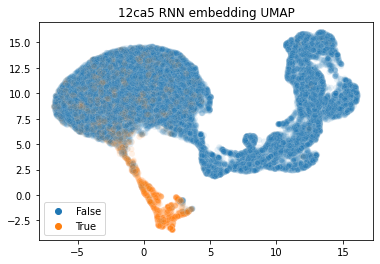

In [ ]:
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=y_train, alpha=0.1)
plt.title("12ca5 RNN embedding UMAP")

In [ ]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_train[i] == 1:
        if x2 < 1.2:
            true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [ ]:
ninemer_seq = []
for seq in ninemer_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:]) # exclude 'A' in position 0 

In [ ]:
len(good_seqs)

1689

In [ ]:
# write results
with open('12ca5_good.txt','w') as fh:
    for i in range(len(ls)):
        fh.write(f'{ls[i]}\n')

In [ ]:
good_seqs

['AFCLGDFAC',
 'AHCTDRRDY',
 'AVCGDYAEC',
 'KDVFRDY',
 'ACLGDYACR',
 'ACVGDYAAC',
 'DYPDYAD',
 'MADSPDY',
 'ACYGDYACF',
 'AGCGDYAAG',
 'DWGDYAL',
 'KVDFRVY',
 'AHCYGDYAC',
 'DDYLDYS',
 'ACWEGEYAC',
 'KVELRDY',
 'AFCLGDYSC',
 'NEDLMDY',
 'YDNPDYS',
 'AECGDYAEC',
 'AYCFGDYSC',
 'ACLGDYSHC',
 'ACFDADYSEC',
 'ADCYGDYAC',
 'AKCWGDYAC',
 'ARCVGVYAC',
 'AQCFGDYAC',
 'ALCGDYSAC',
 'AGCRMLECR',
 'LVDLRVY',
 'ACGDYAVVC',
 'ACVVDYACW',
 'SNVYDYS',
 'ACMGDYASC',
 'AVCTYLECK',
 'KDDLWDY',
 'NEDLLYY',
 'TADMPDY',
 'ATCLDYACW',
 'APCFHLEWR',
 'APCFHLECR',
 'MKDVVDY',
 'ACNFSLCEE',
 'DARDYAG',
 'KEDLSYY',
 'AGWMTWCEE',
 'ACYVDYAAC',
 'ARCVGDYGC',
 'LMDWPDY',
 'AHCGDYAEC',
 'AVWWGDYAC',
 'ASCVGDYSC',
 'DEKDYAA',
 'AKCWGDFAC',
 'KVDLGDF',
 'ACSYTWWEE',
 'ACYGDYAGC',
 'ACSGYYAAC',
 'ACWVYACME',
 'AVCFHLECR',
 'DLYDYAH',
 'AVCSMLECK',
 'SEVYDYS',
 'ACAADLRDY',
 'DVPDYAM',
 'AGCYGDYDC',
 'ADRRDYA',
 'ARCVGDYAF',
 'ATCVGDYAC',
 'DTMDYAY',
 'ACTGDYAWC',
 'MLDLLYV',
 'ACNFDYACW',
 'ALCSGDYAC',
 'ACFADYACL',
 

In [ ]:
for seq in ninemer_seq:
    print(seq)

FCLGDFAC
HCTDRRDY
VCGDYAEC
CLGDYACR
CVGDYAAC
CYGDYACF
GCGDYAAG
HCYGDYAC
CWEGEYAC
FCLGDYSC
ECGDYAEC
YCFGDYSC
CLGDYSHC
DCYGDYAC
KCWGDYAC
RCVGVYAC
QCFGDYAC
LCGDYSAC
GCRMLECR
CGDYAVVC
CVVDYACW
CMGDYASC
VCTYLECK
TCLDYACW
PCFHLEWR
PCFHLECR
CNFSLCEE
GWMTWCEE
CYVDYAAC
RCVGDYGC
HCGDYAEC
VWWGDYAC
SCVGDYSC
KCWGDFAC
CSYTWWEE
CYGDYAGC
CSGYYAAC
CWVYACME
VCFHLECR
VCSMLECK
CAADLRDY
GCYGDYDC
RCVGDYAF
TCVGDYAC
CTGDYAWC
CNFDYACW
LCSGDYAC
CFADYACL
CWDYACWP
CNLPWCEE
GCPMLECK
CRSTWCEE
FCVGDYAC
CLGDYACK
VCPMLECQ
TCFLLECK
KCFGDYAW
CAADMRDY
HCDVMDYG
PCTLMECR
FCLGEYAC
CQHTSCEE
CVGDYAGC
AWGDYAAC
CYGDYACY
CGMTWCEE
RCYGDYDC
PCADYACW
CCFDLGDY
CNGDYAAF
GGLGDYAR
CVGDSACQ
SCFVYACW
GCWGDYAG
HCFHLECR
TCFHLECR
NCTLLECR
YCTLLECR
VCWGDYEC
CPCDYAAC
PCLLLECK
RCAGDYAC
CVWRWCEE
LCQGDYAC
CFAYQCEE
CRATWWEE
CVGDYACA
QCYGDYSC
CVFTFCEE
CWLTWCEE
CSNTLCEE
PCGDYAAC
GCLGDFAC
CLGYYAAC
YCVGDYAC
CVGDYACP
VCWGDYVC
ACFGDYAW
ACFGDYAF
VCPMLECR
CWWTWCEE
CTGDYAAC
LCYGDYAC
CFGDYASC
VCGGDYAC
CFGVYAAC
GCYGDYVC
CDYADQSC
QCFMLECR
CSNTGCEE
RCYWDYAC
C